In [1]:
import pennylane as qml
import tensorflow as tf
import sklearn.datasets
from sklearn.datasets import fetch_openml

import numpy as np
import pandas as pd
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

tf.keras.backend.set_floatx('float64')

## Load MNIST Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)
print(x_train[..., np.newaxis].shape)

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

(60000, 28, 28)
(60000, 28, 28, 1)
Number of original training examples: 60000
Number of original test examples: 10000


## Preprocess Data

In [3]:
digits_to_be_filtered = [3, 6]
resize_dims = (9,9)

In [4]:
def preprocess_data(x_train, x_test):

    # Rescale the images from [0,255] to the [0.0,1.0] range.
    x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0  # add colour dimension

    return x_train, x_test

In [5]:
x_train_preprocessed, x_test_preprocessed = preprocess_data(x_train, x_test)
x_train_preprocessed.shape

(60000, 28, 28, 1)

In [6]:
def filter_digits(x, y, digits=[3, 6]):
    """
    Filter the dataset to only keep the specified digit classes.
    Args:
        x: input images
        y: corresponding labels
        digits: the classes we want to keep
    Returns:
        x_filtered, y_filtered: filtered images and labels
    """
    keep = np.where(np.isin(y, digits))
    x_filtered, y_filtered = x[keep], y[keep]
    
    # Change labels to start from 0 and make them consecutive
    y_filtered = np.array(y_filtered)
    label_mapping = {}
    for i, digit in enumerate(digits):
        y_filtered[y_filtered==digit] = i
        label_mapping[i] = digit
    
    
    return x_filtered, y_filtered, label_mapping
        

In [7]:
x_train_filtered, y_train_filtered, label_mapping = filter_digits(x_train_preprocessed, y_train, digits=digits_to_be_filtered)
x_test_filtered, y_test_filtered, label_mapping = filter_digits(x_test_preprocessed, y_test, digits=digits_to_be_filtered)

print("Number of filtered training examples:", len(x_train_filtered))
print("Number of filtered test examples:", len(x_test_filtered))
print(pd.Series(y_train_filtered).value_counts().sort_index())
print(label_mapping)

Number of filtered training examples: 12049
Number of filtered test examples: 1968
0    6131
1    5918
dtype: int64
{0: 3, 1: 6}


In [8]:
def plot_MNIST_greyscale(x_train,y_train,label_mapping,image_index=0, save_img=False):

    if len(x_train.shape) == 2:
        plt.imshow(x_train[image_index,:].reshape((1,-1)), vmin=0, vmax=1, cmap='Greys')  # vmin=0, vmax=1,
        dim_1 = x_train.shape[1]
        dim_2 = 1
    elif len(x_train.shape) == 3:
        plt.imshow(x_train[image_index, :, :], cmap='Greys')
        dim_1 = x_train.shape[1]
        dim_2 = x_train.shape[2]  
    elif len(x_train.shape) == 4:
        plt.imshow(x_train[image_index, :, :, 0], cmap='Greys')
        dim_1 = x_train.shape[1]
        dim_2 = x_train.shape[2]
        
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    print(x_train.shape)
    plt.title("{}x{} MNIST image of {}".format(dim_1, dim_2, label_mapping[y_train[image_index]]), fontsize=20)
    if save_img:
        plt.savefig('MNIST_{}x{}_{}.pdf'.format(dim_1, dim_2, label_mapping[y_train[image_index]]), bbox_inches='tight', pad_inches=0)
    plt.show()

(12049, 28, 28, 1)


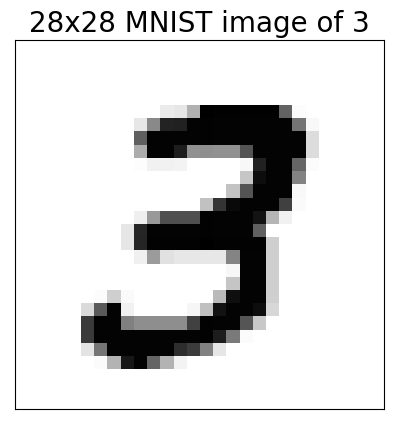

In [9]:
plot_MNIST_greyscale(x_train_filtered,y_train_filtered,label_mapping,image_index=0)

In [10]:
def resize_image(image, target_size=(3,3)):
    resized_image = tf.image.resize(image, target_size).numpy()

    return resized_image

In [11]:
print(x_train_filtered.shape)
x_train_resized = resize_image(x_train_filtered, target_size=resize_dims)
x_test_resized = resize_image(x_test_filtered, target_size=resize_dims)
x_train_resized.shape

(12049, 28, 28, 1)


(12049, 9, 9, 1)

(12049, 9, 9, 1)


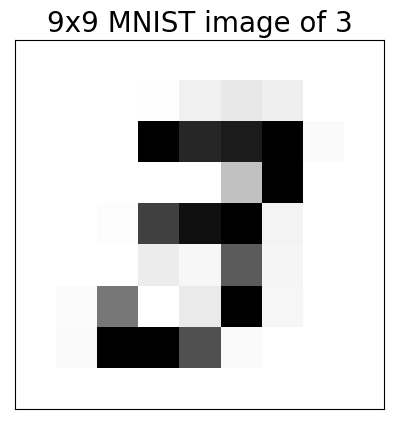

In [12]:
plot_MNIST_greyscale(x_train_resized,y_train_filtered,label_mapping,image_index=0)

In [13]:
# flatten images from shape (1000,28,28,1) to shape (1000,1,784) 

def flatten_images(images):
    num_images, height, width, channels = images.shape
    flattened_images = np.reshape(images, (num_images, height * width * channels))
    return flattened_images




# def flatten_images(images):
#     print(images.shape)
#     flattened_images = images.reshape((-1, images.shape[1]*images.shape[2]))
#     return flattened_images

In [14]:
print(x_train_resized.shape)
x_train_flattened = flatten_images(x_train_resized)
print(x_train_flattened.shape)
x_train_flattened[0]

(12049, 9, 9, 1)
(12049, 81)


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00965871, 0.11764728, 0.1653598 ,
       0.12806845, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.9882353 , 0.8594772 , 0.89546114, 0.9882353 ,
       0.03856194, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.35282016, 0.9882353 , 0.        ,
       0.        , 0.        , 0.        , 0.0245098 , 0.7910676 ,
       0.93235296, 0.9882353 , 0.09520682, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.14547336, 0.06710247,
       0.702711  , 0.08060972, 0.        , 0.        , 0.        ,
       0.02879458, 0.6000127 , 0.        , 0.15577365, 0.983999  ,
       0.07352912, 0.        , 0.        , 0.        , 0.04934643,
       0.9882353 , 0.9882353 , 0.74182993, 0.04208412, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [15]:
def slice_image(image, slice_axis='horizontal', centre_slice=True, central_fraction=0.1):
    """
    Slice images along the specified axis by taking a central fraction of pixels.

    Args:
    data (numpy.ndarray): The input images with shape (num_images, height, width).
    slice_axis (str): Either 'horizontal' or 'vertical' for row or column slicing, respectively.
    centre_slice (bool): Whether to take the central slice or not.
    central_fraction (float): The fraction of central pixels to be taken (e.g., 0.5 for half of the pixels).

    Returns:
    numpy.ndarray: The sliced images.
    """
    assert 0 < central_fraction <= 1, "central_fraction must be in (0, 1]"
    assert image.ndim == 4, "Input data must have 3 dimensions: (num_images, height, width, channels)"
    assert slice_axis in ['horizontal', 'vertical'], "slice_axis must be 'horizontal' or 'vertical'"

    num_images, height, width, channels = image.shape

    if slice_axis == 'horizontal':
        if centre_slice:
            print(height//2)
            sliced_data = image[:, height//2, :, :].reshape((-1,height))
        else:
            start_row = int((1 - central_fraction) * height / 2)
            end_row = height - start_row
            sliced_data = image[:, start_row:end_row, :, :].reshape((-1,height))
    else:  # slice_axis == 'vertical'
        if centre_slice:
            print(width//2)
            sliced_data = image[:, width//2, :, :].reshape((-1,width))
        else:
            start_col = int((1 - central_fraction) * width / 2)
            end_col = width - start_col
            sliced_data = image[:, :, start_col:end_col, :].reshape((-1,width))

    return sliced_data

In [16]:
start_row = int((1 - 1/9) * 9 / 2)
end_row = 9 - start_row
print(start_row, end_row)

4 5


In [17]:
print(x_train_resized.shape)
x_train_sliced = slice_image(x_train_resized, slice_axis='horizontal', centre_slice=True, central_fraction=1/x_train_resized.shape[1])
x_test_sliced = slice_image(x_test_resized, slice_axis='horizontal', centre_slice=True, central_fraction=1/x_train_resized.shape[1])
x_train_sliced.shape

(12049, 9, 9, 1)
4
4


(12049, 9)

(12049, 9)


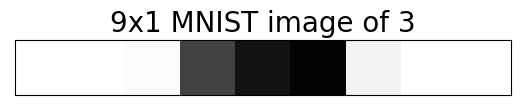

In [18]:
plot_MNIST_greyscale(x_train_sliced,y_train_filtered,label_mapping,image_index=0)

In [19]:
x_train_sliced[0]

array([0.        , 0.        , 0.0245098 , 0.7910676 , 0.93235296,
       0.9882353 , 0.09520682, 0.        , 0.        ], dtype=float32)

In [20]:
x_train_final = x_train_sliced
y_train_final = y_train_filtered
x_test_final = x_test_sliced
y_test_final = y_test_filtered
x_train_final.shape

(12049, 9)

## Build Quantum ML Model

In [21]:
n_qubits = 9
n_layers = 1

In [77]:
import math
def frqi_encoding_single_image(image_vector):
    frqi_encoded_image = []
    for i in range(len(image_vector)):
        frqi_encoded_image.append((1/np.sqrt(2))*(math.cos((math.pi*image_vector[i])/2)))
        frqi_encoded_image.append((1/np.sqrt(2))*(math.sin((math.pi*image_vector[i])/2)))
    return frqi_encoded_image

def frqi_encoding_all_images(images):
    frqi_encoded_images = []
    for i in range(images.shape[0]):
        frqi_encoded_image = frqi_encoding_single_image(image_vector=images[i])
        frqi_encoded_images.append(frqi_encoded_image)
    return np.array(frqi_encoded_images)

In [78]:
x_train_frqi_encoded = frqi_encoding_all_images(x_train_final)
print(x_train_frqi_encoded.shape)
x_test_frqi_encoded = frqi_encoding_all_images(x_test_final)
print(x_test_frqi_encoded.shape)

(12049, 1568)
(1968, 1568)


59
[('RZ', None, 0, (0, 0)), ('RY', None, 0, (0, 1)), ('RZ', None, 0, (0, 2)), ('RZ', None, 1, (1, 0)), ('RY', None, 1, (1, 1)), ('RZ', None, 1, (1, 2)), ('CNOT', 1, 0, None), ('RZ', None, 0, (2, 0)), ('RY', None, 0, (2, 1)), ('RZ', None, 0, (2, 2)), ('RZ', None, 2, (3, 0)), ('RY', None, 2, (3, 1)), ('RZ', None, 2, (3, 2)), ('CNOT', 2, 0, None), ('RZ', None, 0, (4, 0)), ('RY', None, 0, (4, 1)), ('RZ', None, 0, (4, 2)), ('RZ', None, 3, (5, 0)), ('RY', None, 3, (5, 1)), ('RZ', None, 3, (5, 2)), ('CNOT', 3, 0, None), ('RZ', None, 0, (6, 0)), ('RY', None, 0, (6, 1)), ('RZ', None, 0, (6, 2)), ('RZ', None, 4, (7, 0)), ('RY', None, 4, (7, 1)), ('RZ', None, 4, (7, 2)), ('CNOT', 4, 0, None), ('RZ', None, 0, (8, 0)), ('RY', None, 0, (8, 1)), ('RZ', None, 0, (8, 2)), ('RZ', None, 5, (9, 0)), ('RY', None, 5, (9, 1)), ('RZ', None, 5, (9, 2)), ('CNOT', 5, 0, None), ('RZ', None, 0, (10, 0)), ('RY', None, 0, (10, 1)), ('RZ', None, 0, (10, 2)), ('RZ', None, 6, (11, 0)), ('RY', None, 6, (11, 1)), ('RZ',

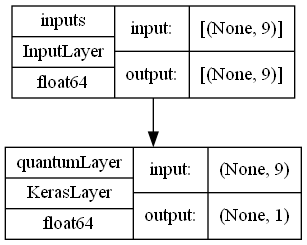

In [22]:
def create_quantum_model(n_qubits, n_layers, gate_sequence, input_shape, encoding="basis", diff_method="adjoint"):
    print("Number of qubits: ", n_qubits)
    print("Number of layers: ", n_layers)
    print("Gate sequence: ", gate_sequence)
    print("Input shape: ", input_shape)
    print("Encoding: ", encoding)
    print("Diff method: ", diff_method)

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, diff_method=diff_method)  # ["best","backprop","adjoint","device","parameter-shift","finite-diff","hadamard","spsa"]
    def qnode(inputs, weights):
        # Apply input rotations
        if encoding=="basis":
            for i in range(n_qubits):
                qml.RY(np.pi * inputs[i], wires=i)
        elif encoding=="amplitude":
            qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits),normalize=True,pad_with=0)
        elif encoding=="FRQI":
            for i in range(n_qubits):
                qml.RY(np.pi * inputs[i], wires=i)

        # Apply quantum layers
        for layer_idx in range(n_layers):
            for gate_type, control_wire, target_wire, weight_idx in gate_sequence:
                if gate_type == "RY":
                    qml.RY(weights[layer_idx, weight_idx[0], weight_idx[1]], wires=target_wire)
                elif gate_type == "RZ":
                    qml.RZ(weights[layer_idx, weight_idx[0], weight_idx[1]], wires=target_wire)
                elif gate_type == "CNOT":
                    qml.CNOT(wires=[control_wire, target_wire])
                # Add more gate types here as needed
            
            

        # Measure the expectation value of Pauli-Z on wire 0
        return qml.expval(qml.PauliZ(0))

    # Define weight shapes for the KerasLayer
    weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3)}

    # Create the quantum layer with the qnode and weight_shapes
    qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")

    # Create the Keras input layer with the shape of the inputs
    inputs = tf.keras.Input(shape=(input_shape,), name="inputs")

    # Connect the quantum layer to the inputs
    outputs = qlayer(inputs)

    # Create the Keras model with the inputs and outputs
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

    return model, qnode


gate_sequence = []

for ii in range(n_qubits - 1):
    gate_sequence.extend([
        ("RZ", None, 0, (2 * ii, 0)),
        ("RY", None, 0, (2 * ii, 1)),
        ("RZ", None, 0, (2 * ii, 2)),
        ("RZ", None, ii + 1, (2 * ii + 1, 0)),
        ("RY", None, ii + 1, (2 * ii + 1, 1)),
        ("RZ", None, ii + 1, (2 * ii + 1, 2)),
        ("CNOT", ii + 1, 0, None),
    ])

gate_sequence.extend([
    ("RZ", None, 0, (2 * (n_qubits - 1), 0)),
    ("RY", None, 0, (2 * (n_qubits - 1), 1)),
    ("RZ", None, 0, (2 * (n_qubits - 1), 2)),
])

print(len(gate_sequence))
print(gate_sequence)

test_model, test_q_node = create_quantum_model(n_qubits, n_layers, gate_sequence, input_shape=n_qubits, encoding="basis", diff_method="adjoint")
test_model.predict(x_train_final[0,:])
print(test_model.summary())
plot_model(test_model, to_file="test_quantum_ml_model.png", show_shapes=True, show_dtype=True, show_layer_names=True)

In [23]:
def draw_quantum_circuit(q_node, n_qubits, n_layers):
    circuit_diagram = qml.draw(q_node)
    sample_inputs = np.random.rand(n_qubits)
    sample_weights = np.random.rand(n_layers, 2*(n_qubits-1)+1, 3)

    print(circuit_diagram(sample_inputs, sample_weights))

In [24]:
draw_quantum_circuit(test_q_node, n_qubits, n_layers)

0: ──RY(2.99)──RZ(0.60)──RY(0.26)──RZ(0.74)─╭X──RZ(0.29)──RY(0.64)──RZ(0.35)─╭X──RZ(0.11)──RY(0.79)
1: ──RY(0.98)──RZ(0.50)──RY(0.08)──RZ(0.71)─╰●───────────────────────────────│─────────────────────
2: ──RY(1.11)──RZ(0.37)──RY(0.10)──RZ(0.76)──────────────────────────────────╰●────────────────────
3: ──RY(2.63)──RZ(0.42)──RY(0.89)──RZ(0.70)────────────────────────────────────────────────────────
4: ──RY(0.06)──RZ(0.74)──RY(0.38)──RZ(0.64)────────────────────────────────────────────────────────
5: ──RY(1.61)──RZ(0.20)──RY(0.87)──RZ(0.55)────────────────────────────────────────────────────────
6: ──RY(1.04)──RZ(0.78)──RY(0.75)──RZ(0.95)────────────────────────────────────────────────────────
7: ──RY(0.20)──RZ(0.38)──RY(0.91)──RZ(0.19)────────────────────────────────────────────────────────
8: ──RY(1.29)──RZ(0.54)──RY(0.36)──RZ(0.71)────────────────────────────────────────────────────────

───RZ(0.72)─╭X──RZ(0.60)──RY(0.13)──RZ(0.83)─╭X──RZ(0.24)──RY(0.94)──RZ(0.27)─╭X──RZ(0.76)──RY(0.69

In [25]:
def get_hinge_labels(labels):
    return 2.0*labels - 1.0

In [26]:
y_train_hinge = get_hinge_labels(y_train_final)
y_test_hinge = get_hinge_labels(y_test_final)
y_train_hinge[:10]

array([-1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.])

In [27]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

## Compile and train model

In [28]:
EPOCHS = 20 # Number of training epochs
BATCH_SIZE = 32 # Number of examples used in each training step

NUM_EXAMPLES = 512 # Number of examples to train on

In [29]:
test_model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [30]:
x_train_sub = x_train_final[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]
print(x_train_sub.shape, y_train_hinge_sub.shape)

x_test_sub = x_test_final[:,:]
y_test_sub = y_test_filtered[:]
print(x_test_sub.shape, y_test_sub.shape)

(512, 9) (512,)
(1968, 9) (1968,)


In [31]:
# x_train_sub = x_train_final[:NUM_EXAMPLES,:]
# y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

# x_test_sub = x_test_final[:,:]
# y_test_sub = y_test_hinge[:]

# qnn_history_1layer = test_model.fit(
#       x_train_sub, y_train_hinge_sub,
#       batch_size=BATCH_SIZE,
#       epochs=EPOCHS,
#       verbose=1,
#       validation_data=(x_test_sub, y_test_sub))

# qnn_results_1layer = test_model.evaluate(x_test_sub, y_test_sub)

In [32]:
qnn_history_1layer.history

NameError: name 'qnn_history_1layer' is not defined

## Experimentation

In [33]:
ansatz_list = []

# ansatz 1
n_qubits=9
print(n_qubits)
gate_sequence_1 = []
for ii in range(n_qubits - 1):
    gate_sequence_1.extend([
        ("RZ", None, 0, (2 * ii, 0)),
        ("RY", None, 0, (2 * ii, 1)),
        ("RZ", None, 0, (2 * ii, 2)),
        ("RZ", None, ii + 1, (2 * ii + 1, 0)),
        ("RY", None, ii + 1, (2 * ii + 1, 1)),
        ("RZ", None, ii + 1, (2 * ii + 1, 2)),
        ("CNOT", ii + 1, 0, None),
    ])

gate_sequence_1.extend([
    ("RZ", None, 0, (2 * (n_qubits - 1), 0)),
    ("RY", None, 0, (2 * (n_qubits - 1), 1)),
    ("RZ", None, 0, (2 * (n_qubits - 1), 2)),
])
ansatz_list.append(gate_sequence_1)

# ansatz 2
n_qubits=7
print(n_qubits)
gate_sequence_2 = []
for ii in range(n_qubits - 1):
    gate_sequence_2.extend([
        ("RZ", None, 0, (2 * ii, 0)),
        ("RY", None, 0, (2 * ii, 1)),
        ("RZ", None, 0, (2 * ii, 2)),
        ("RZ", None, ii + 1, (2 * ii + 1, 0)),
        ("RY", None, ii + 1, (2 * ii + 1, 1)),
        ("RZ", None, ii + 1, (2 * ii + 1, 2)),
        ("CNOT", ii + 1, 0, None),
    ])

gate_sequence_2.extend([
    ("RZ", None, 0, (2 * (n_qubits - 1), 0)),
    ("RY", None, 0, (2 * (n_qubits - 1), 1)),
    ("RZ", None, 0, (2 * (n_qubits - 1), 2)),
])
ansatz_list.append(gate_sequence_2)

# ansatz 3
n_qubits=8
print(n_qubits)
gate_sequence_3 = []
for ii in range(n_qubits - 1):
    gate_sequence_3.extend([
        ("RZ", None, 0, (2 * ii, 0)),
        ("RY", None, 0, (2 * ii, 1)),
        ("RZ", None, 0, (2 * ii, 2)),
        ("RZ", None, ii + 1, (2 * ii + 1, 0)),
        ("RY", None, ii + 1, (2 * ii + 1, 1)),
        ("RZ", None, ii + 1, (2 * ii + 1, 2)),
        ("CNOT", ii + 1, 0, None),
    ])

gate_sequence_3.extend([
    ("RZ", None, 0, (2 * (n_qubits - 1), 0)),
    ("RY", None, 0, (2 * (n_qubits - 1), 1)),
    ("RZ", None, 0, (2 * (n_qubits - 1), 2)),
])
ansatz_list.append(gate_sequence_3)

# ansatz 4
n_qubits=10
print(n_qubits)
gate_sequence_4 = []
for ii in range(n_qubits - 1):
    gate_sequence_4.extend([
        ("RZ", None, 0, (2 * ii, 0)),
        ("RY", None, 0, (2 * ii, 1)),
        ("RZ", None, 0, (2 * ii, 2)),
        ("RZ", None, ii + 1, (2 * ii + 1, 0)),
        ("RY", None, ii + 1, (2 * ii + 1, 1)),
        ("RZ", None, ii + 1, (2 * ii + 1, 2)),
        ("CNOT", ii + 1, 0, None),
    ])

gate_sequence_4.extend([
    ("RZ", None, 0, (2 * (n_qubits - 1), 0)),
    ("RY", None, 0, (2 * (n_qubits - 1), 1)),
    ("RZ", None, 0, (2 * (n_qubits - 1), 2)),
])
ansatz_list.append(gate_sequence_4)

# ansatz 5
n_qubits=11
print(n_qubits)
gate_sequence_5 = []
for ii in range(n_qubits - 1):
    gate_sequence_5.extend([
        ("RZ", None, 0, (2 * ii, 0)),
        ("RY", None, 0, (2 * ii, 1)),
        ("RZ", None, 0, (2 * ii, 2)),
        ("RZ", None, ii + 1, (2 * ii + 1, 0)),
        ("RY", None, ii + 1, (2 * ii + 1, 1)),
        ("RZ", None, ii + 1, (2 * ii + 1, 2)),
        ("CNOT", ii + 1, 0, None),
    ])

gate_sequence_5.extend([
    ("RZ", None, 0, (2 * (n_qubits - 1), 0)),
    ("RY", None, 0, (2 * (n_qubits - 1), 1)),
    ("RZ", None, 0, (2 * (n_qubits - 1), 2)),
])
ansatz_list.append(gate_sequence_5)


print(len(ansatz_list))
print(len(ansatz_list[0]), len(ansatz_list[1]), len(ansatz_list[2]), len(ansatz_list[3]), len(ansatz_list[4]))

9
7
8
10
11
5
59 45 52 66 73


In [34]:
import json

experiments = {}
# [3,6], 9x9, centre_h_slicing, 9 qubits, ansatz 1, basis encoding, adjoint diff
experiments["1"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":True, "n_qubits":9, "n_layers":1, "gate_sequence":ansatz_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
experiments["2"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":True, "n_qubits":9, "n_layers":2, "gate_sequence":ansatz_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
experiments["3"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":True, "n_qubits":9, "n_layers":3, "gate_sequence":ansatz_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
# [3,6], 3x3, 9 qubits, ansatz 1, basis encoding, adjoint diff
experiments["4"] = {"digits_to_be_filtered":[3,6], "resize_dims":(3,3), "centre_h_slicing":False, "n_qubits":9, "n_layers":1, "gate_sequence":ansatz_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
experiments["5"] = {"digits_to_be_filtered":[3,6], "resize_dims":(3,3), "centre_h_slicing":False, "n_qubits":9, "n_layers":2, "gate_sequence":ansatz_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
experiments["6"] = {"digits_to_be_filtered":[3,6], "resize_dims":(3,3), "centre_h_slicing":False, "n_qubits":9, "n_layers":3, "gate_sequence":ansatz_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
# [3,6], 9x9, 7 qubits, ansatz 2, amplitude encoding, adjoint diff
experiments["7"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":7, "n_layers":1, "gate_sequence":ansatz_list[1], "input_shape":81, "encoding":"amplitude", "diff_method":"adjoint"}
experiments["8"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":7, "n_layers":2, "gate_sequence":ansatz_list[1], "input_shape":81, "encoding":"amplitude", "diff_method":"adjoint"}
experiments["9"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":7, "n_layers":3, "gate_sequence":ansatz_list[1], "input_shape":81, "encoding":"amplitude", "diff_method":"adjoint"}
# [3,6], None, 10 qubits, ansatz 4, amplitude encoding, adjoint diff
experiments["10"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":10, "n_layers":1, "gate_sequence":ansatz_list[3], "input_shape":784, "encoding":"amplitude", "diff_method":"adjoint"}
experiments["11"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":10, "n_layers":2, "gate_sequence":ansatz_list[3], "input_shape":784, "encoding":"amplitude", "diff_method":"adjoint"}
experiments["12"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":10, "n_layers":3, "gate_sequence":ansatz_list[3], "input_shape":784, "encoding":"amplitude", "diff_method":"adjoint"}
# [3,6], 9x9, 8 qubits, ansatz 3, FRQI encoding, adjoint diff
experiments["13"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":1, "gate_sequence":ansatz_list[2], "input_shape":162, "encoding":"FRQI", "diff_method":"adjoint"}
experiments["14"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":2, "gate_sequence":ansatz_list[2], "input_shape":162, "encoding":"FRQI", "diff_method":"adjoint"}
experiments["15"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "gate_sequence":ansatz_list[2], "input_shape":162, "encoding":"FRQI", "diff_method":"adjoint"}
# [3,6], None, 11 qubits, ansatz 5, FRQI encoding, adjoint diff
experiments["16"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":11, "n_layers":1, "gate_sequence":ansatz_list[4], "input_shape":1568, "encoding":"FRQI", "diff_method":"adjoint"}
experiments["17"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":11, "n_layers":2, "gate_sequence":ansatz_list[4], "input_shape":1568, "encoding":"FRQI", "diff_method":"adjoint"}
experiments["18"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":11, "n_layers":3, "gate_sequence":ansatz_list[4], "input_shape":1568, "encoding":"FRQI", "diff_method":"adjoint"}



#-  save the experiments dictionary to a json file
with open('encoding_experiments.json', 'w') as fp:
    json.dump(experiments, fp)

#-  load the experiments dictionary from a json file
with open('encoding_experiments.json', 'r') as fp:
    experiments = json.load(fp)

experiments["2"]

{'digits_to_be_filtered': [3, 6],
 'resize_dims': [9, 9],
 'centre_h_slicing': True,
 'n_qubits': 9,
 'n_layers': 2,
 'gate_sequence': [['RZ', None, 0, [0, 0]],
  ['RY', None, 0, [0, 1]],
  ['RZ', None, 0, [0, 2]],
  ['RZ', None, 1, [1, 0]],
  ['RY', None, 1, [1, 1]],
  ['RZ', None, 1, [1, 2]],
  ['CNOT', 1, 0, None],
  ['RZ', None, 0, [2, 0]],
  ['RY', None, 0, [2, 1]],
  ['RZ', None, 0, [2, 2]],
  ['RZ', None, 2, [3, 0]],
  ['RY', None, 2, [3, 1]],
  ['RZ', None, 2, [3, 2]],
  ['CNOT', 2, 0, None],
  ['RZ', None, 0, [4, 0]],
  ['RY', None, 0, [4, 1]],
  ['RZ', None, 0, [4, 2]],
  ['RZ', None, 3, [5, 0]],
  ['RY', None, 3, [5, 1]],
  ['RZ', None, 3, [5, 2]],
  ['CNOT', 3, 0, None],
  ['RZ', None, 0, [6, 0]],
  ['RY', None, 0, [6, 1]],
  ['RZ', None, 0, [6, 2]],
  ['RZ', None, 4, [7, 0]],
  ['RY', None, 4, [7, 1]],
  ['RZ', None, 4, [7, 2]],
  ['CNOT', 4, 0, None],
  ['RZ', None, 0, [8, 0]],
  ['RY', None, 0, [8, 1]],
  ['RZ', None, 0, [8, 2]],
  ['RZ', None, 5, [9, 0]],
  ['RY', None,

In [35]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)
print(x_train[..., np.newaxis].shape)

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))
print(y_train.shape, y_test.shape)

# Normalize pixel values
x_train_norm = x_train[..., np.newaxis] / 255.0
x_test_norm = x_test[..., np.newaxis] / 255.0

print("x_train shape:", x_train_norm.shape)
print("x_test shape:", x_test_norm.shape)

(60000, 28, 28)
(60000, 28, 28, 1)
Number of original training examples: 60000
Number of original test examples: 10000
(60000,) (10000,)
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


1 {'digits_to_be_filtered': [3, 6], 'resize_dims': [9, 9], 'centre_h_slicing': True, 'n_qubits': 9, 'n_layers': 1, 'gate_sequence': [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ', 

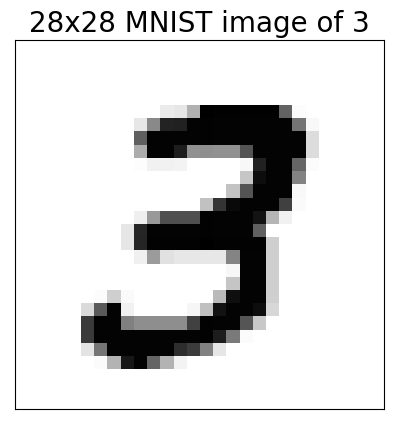

x_train_resized shape: (12049, 9, 9, 1)
x_test_resized shape: (1968, 9, 9, 1)
(12049, 9, 9, 1)


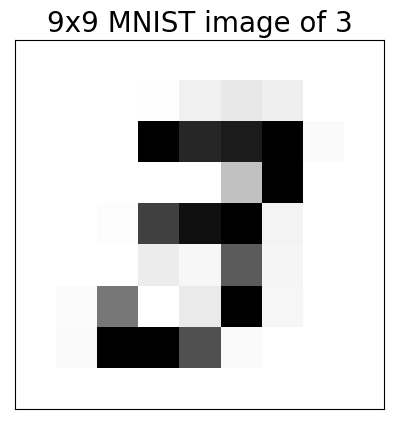

4
4
x_train_sliced shape: (12049, 9)
x_test_sliced shape: (1968, 9)
[0.         0.         0.0245098  0.7910676  0.93235296 0.9882353
 0.09520682 0.         0.        ]
(12049, 9)


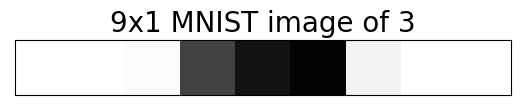

Number of qubits:  9
Number of layers:  1
Gate sequence:  [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ', None, 0, [10, 0]], ['RY', None, 0, [10, 1]], ['RZ', None, 0, [10, 2]], ['R

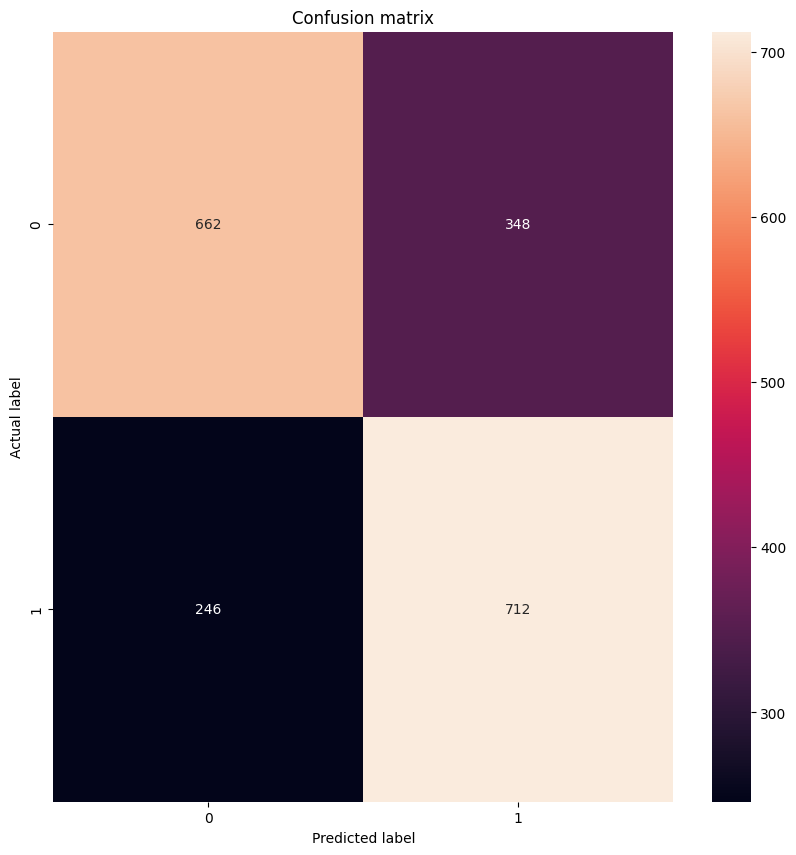

2 {'digits_to_be_filtered': [3, 6], 'resize_dims': [9, 9], 'centre_h_slicing': True, 'n_qubits': 9, 'n_layers': 2, 'gate_sequence': [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ', 

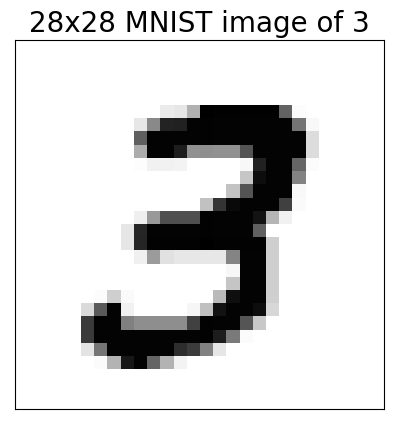

x_train_resized shape: (12049, 9, 9, 1)
x_test_resized shape: (1968, 9, 9, 1)
(12049, 9, 9, 1)


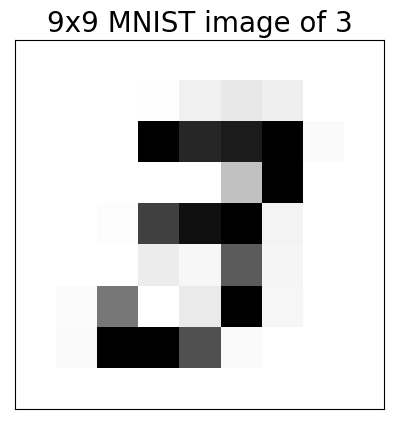

4
4
x_train_sliced shape: (12049, 9)
x_test_sliced shape: (1968, 9)
[0.         0.         0.0245098  0.7910676  0.93235296 0.9882353
 0.09520682 0.         0.        ]
(12049, 9)


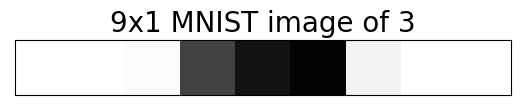

Number of qubits:  9
Number of layers:  2
Gate sequence:  [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ', None, 0, [10, 0]], ['RY', None, 0, [10, 1]], ['RZ', None, 0, [10, 2]], ['R

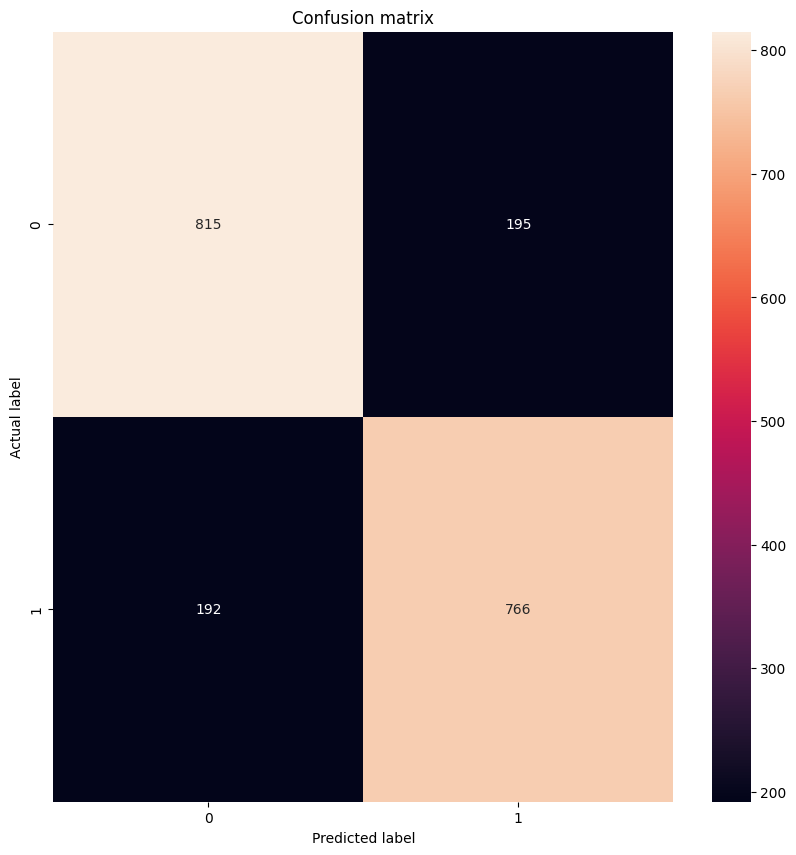

3 {'digits_to_be_filtered': [3, 6], 'resize_dims': [9, 9], 'centre_h_slicing': True, 'n_qubits': 9, 'n_layers': 3, 'gate_sequence': [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ', 

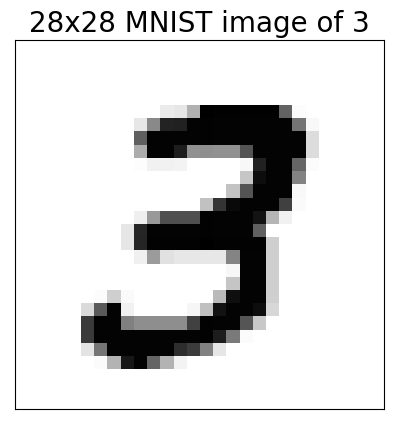

x_train_resized shape: (12049, 9, 9, 1)
x_test_resized shape: (1968, 9, 9, 1)
(12049, 9, 9, 1)


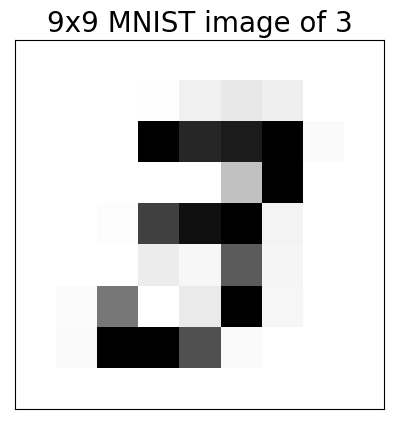

4
4
x_train_sliced shape: (12049, 9)
x_test_sliced shape: (1968, 9)
[0.         0.         0.0245098  0.7910676  0.93235296 0.9882353
 0.09520682 0.         0.        ]
(12049, 9)


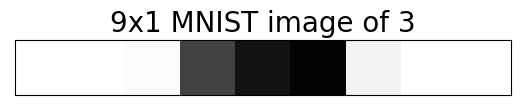

Number of qubits:  9
Number of layers:  3
Gate sequence:  [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ', None, 0, [10, 0]], ['RY', None, 0, [10, 1]], ['RZ', None, 0, [10, 2]], ['R

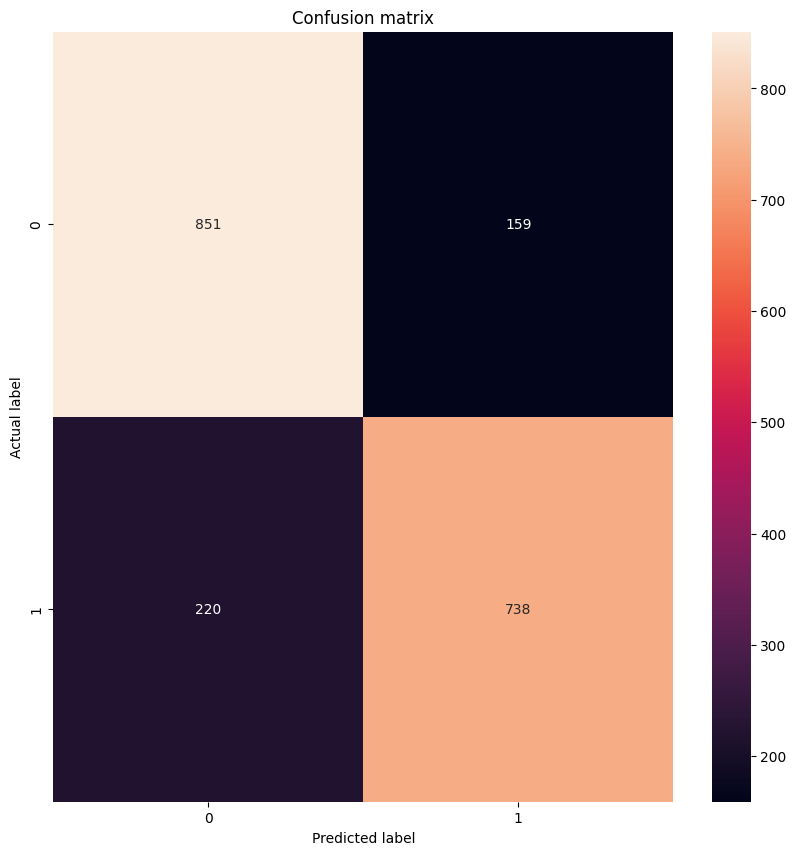

4 {'digits_to_be_filtered': [3, 6], 'resize_dims': [3, 3], 'centre_h_slicing': False, 'n_qubits': 9, 'n_layers': 1, 'gate_sequence': [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ',

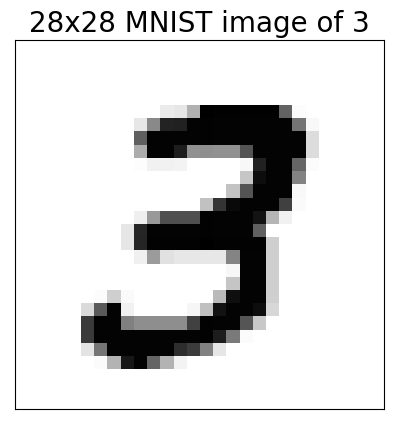

x_train_resized shape: (12049, 3, 3, 1)
x_test_resized shape: (1968, 3, 3, 1)
(12049, 3, 3, 1)


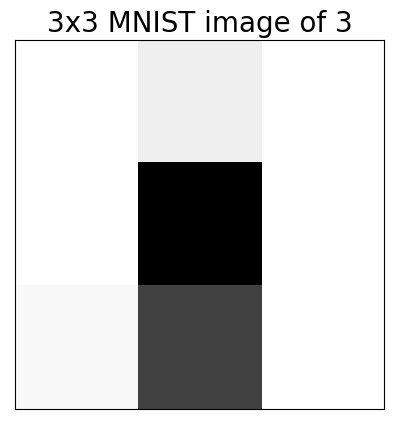

x_train_flattened shape: (12049, 9)
x_test_flattened shape: (1968, 9)
[0.         0.11764694 0.         0.         0.93235296 0.
 0.04934649 0.74183047 0.        ]
(12049, 9)


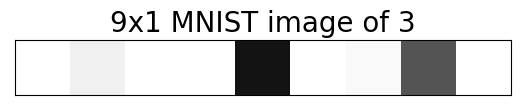

Number of qubits:  9
Number of layers:  1
Gate sequence:  [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ', None, 0, [10, 0]], ['RY', None, 0, [10, 1]], ['RZ', None, 0, [10, 2]], ['R

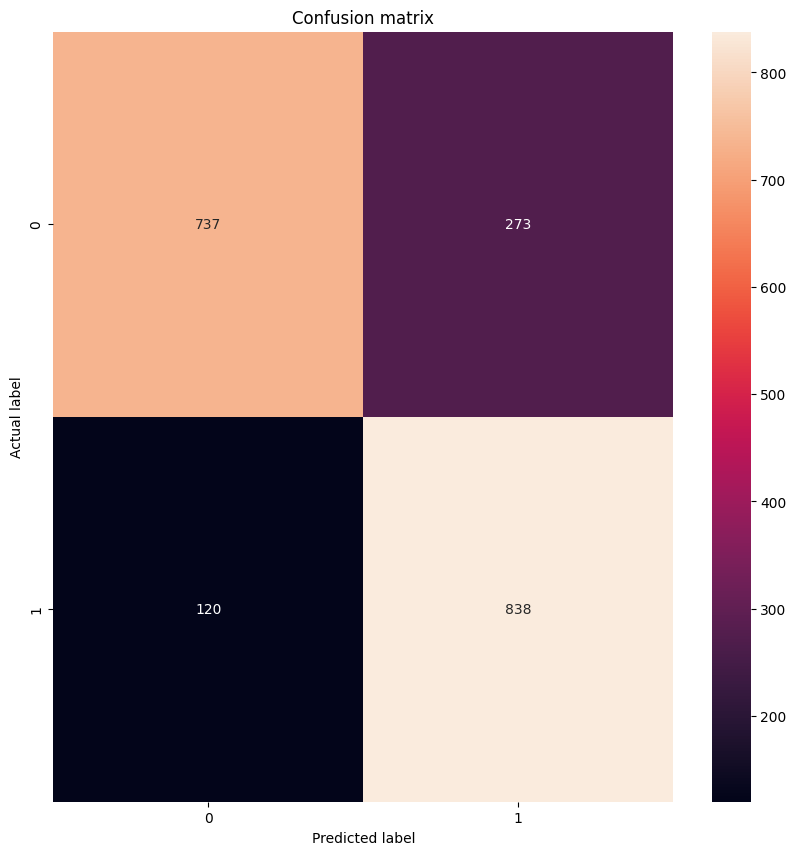

5 {'digits_to_be_filtered': [3, 6], 'resize_dims': [3, 3], 'centre_h_slicing': False, 'n_qubits': 9, 'n_layers': 2, 'gate_sequence': [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ',

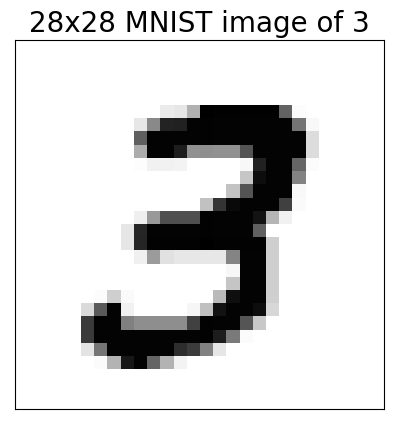

x_train_resized shape: (12049, 3, 3, 1)
x_test_resized shape: (1968, 3, 3, 1)
(12049, 3, 3, 1)


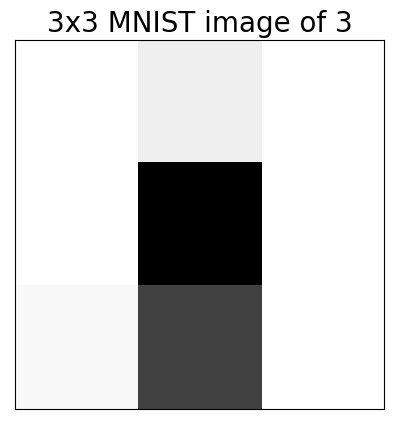

x_train_flattened shape: (12049, 9)
x_test_flattened shape: (1968, 9)
[0.         0.11764694 0.         0.         0.93235296 0.
 0.04934649 0.74183047 0.        ]
(12049, 9)


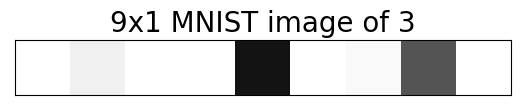

Number of qubits:  9
Number of layers:  2
Gate sequence:  [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ', None, 0, [10, 0]], ['RY', None, 0, [10, 1]], ['RZ', None, 0, [10, 2]], ['R

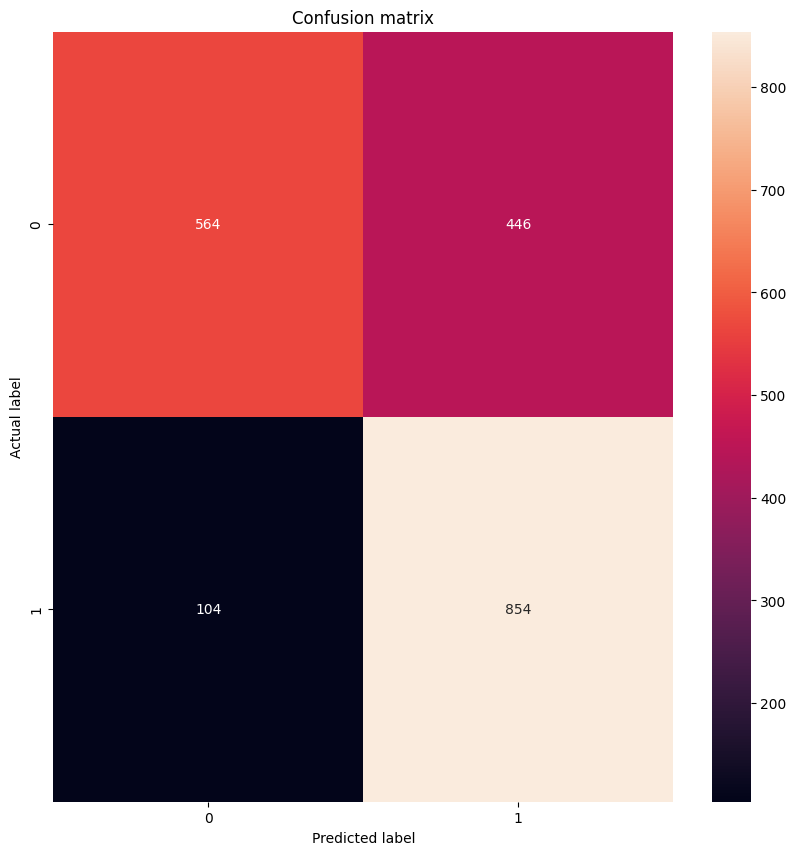

6 {'digits_to_be_filtered': [3, 6], 'resize_dims': [3, 3], 'centre_h_slicing': False, 'n_qubits': 9, 'n_layers': 3, 'gate_sequence': [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ',

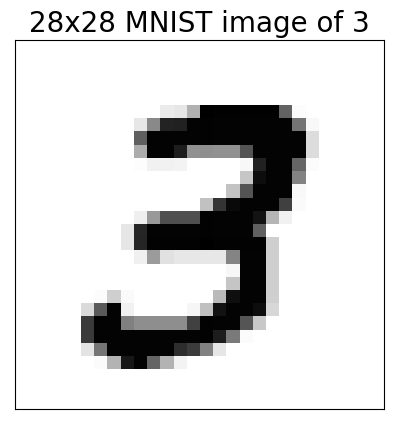

x_train_resized shape: (12049, 3, 3, 1)
x_test_resized shape: (1968, 3, 3, 1)
(12049, 3, 3, 1)


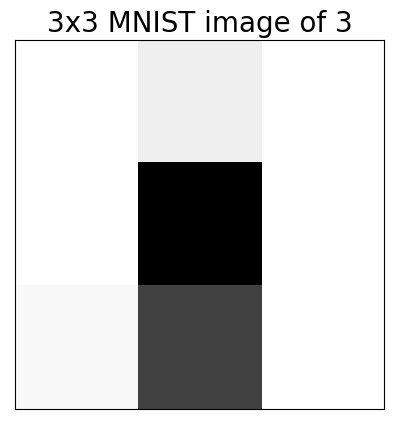

x_train_flattened shape: (12049, 9)
x_test_flattened shape: (1968, 9)
[0.         0.11764694 0.         0.         0.93235296 0.
 0.04934649 0.74183047 0.        ]
(12049, 9)


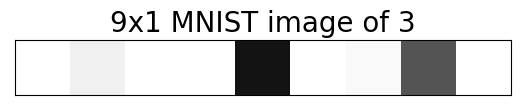

Number of qubits:  9
Number of layers:  3
Gate sequence:  [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ', None, 0, [10, 0]], ['RY', None, 0, [10, 1]], ['RZ', None, 0, [10, 2]], ['R

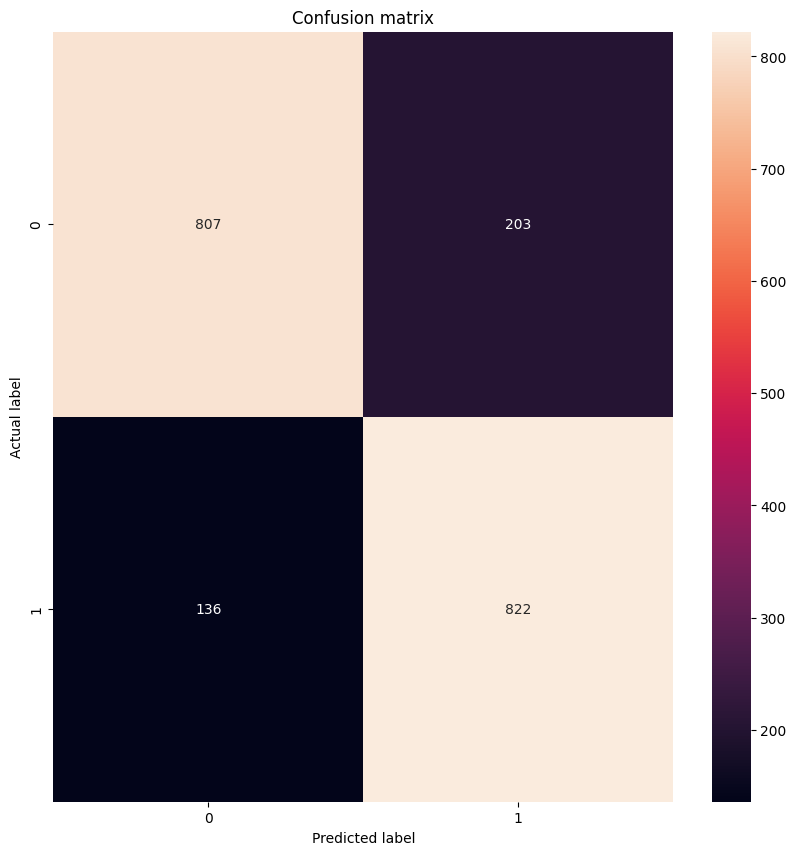

7 {'digits_to_be_filtered': [3, 6], 'resize_dims': [9, 9], 'centre_h_slicing': False, 'n_qubits': 7, 'n_layers': 1, 'gate_sequence': [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ',

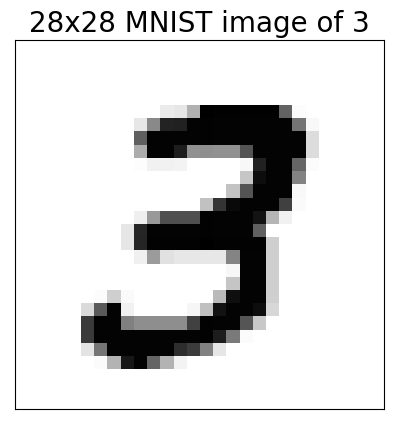

x_train_resized shape: (12049, 9, 9, 1)
x_test_resized shape: (1968, 9, 9, 1)
(12049, 9, 9, 1)


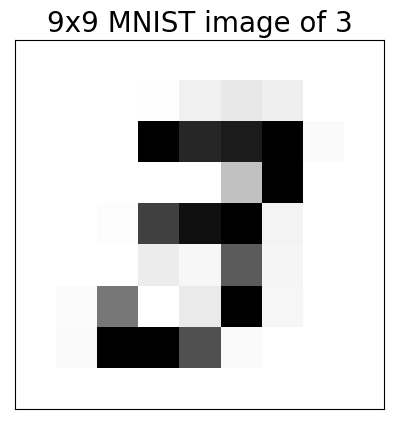

x_train_flattened shape: (12049, 81)
x_test_flattened shape: (1968, 81)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00965871 0.11764728 0.1653598  0.12806845 0.         0.
 0.         0.         0.         0.9882353  0.8594772  0.89546114
 0.9882353  0.03856194 0.         0.         0.         0.
 0.         0.         0.35282016 0.9882353  0.         0.
 0.         0.         0.0245098  0.7910676  0.93235296 0.9882353
 0.09520682 0.         0.         0.         0.         0.
 0.14547336 0.06710247 0.702711   0.08060972 0.         0.
 0.         0.02879458 0.6000127  0.         0.15577365 0.983999
 0.07352912 0.         0.         0.         0.04934643 0.9882353
 0.9882353  0.74182993 0.04208412 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
(12049, 81)


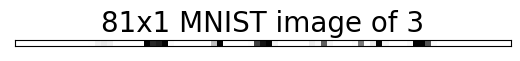

Number of qubits:  7
Number of layers:  1
Gate sequence:  [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ', None, 0, [10, 0]], ['RY', None, 0, [10, 1]], ['RZ', None, 0, [10, 2]], ['R

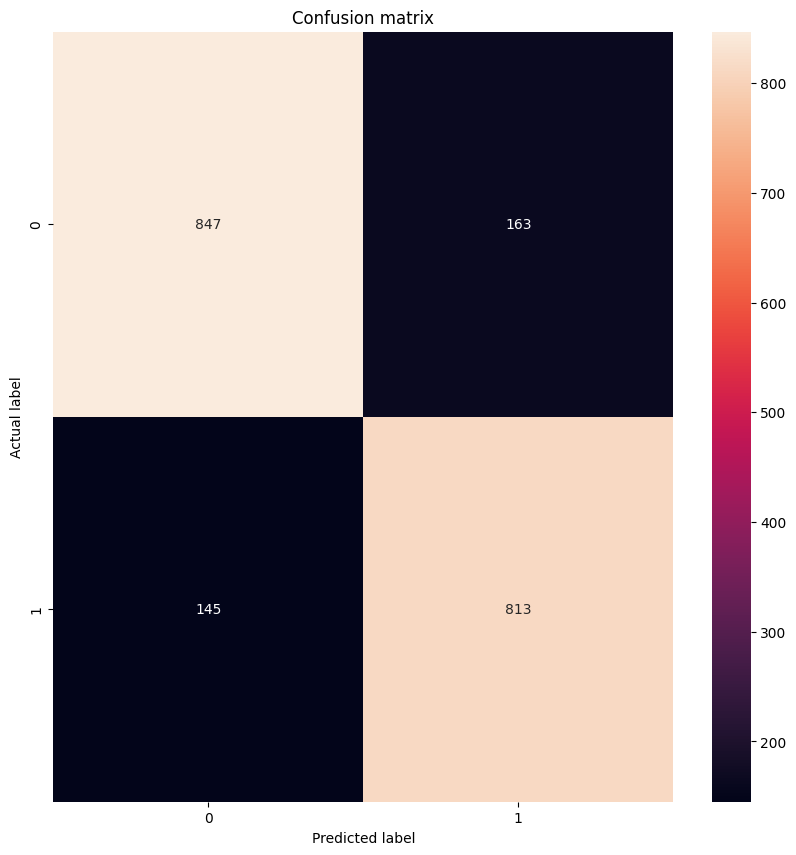

Skipping experiment 8
Skipping experiment 9
10 {'digits_to_be_filtered': [3, 6], 'resize_dims': None, 'centre_h_slicing': False, 'n_qubits': 10, 'n_layers': 1, 'gate_sequence': [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', No

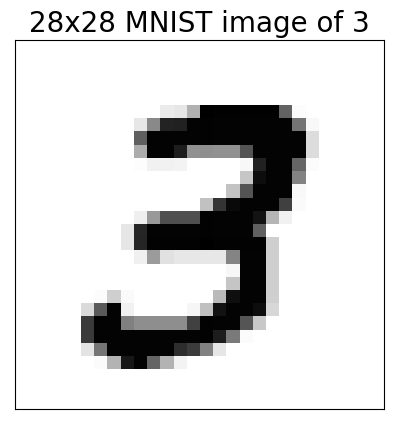

x_train_flattened shape: (12049, 784)
x_test_flattened shape: (1968, 784)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.     

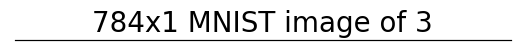

Number of qubits:  10
Number of layers:  1
Gate sequence:  [['RZ', None, 0, [0, 0]], ['RY', None, 0, [0, 1]], ['RZ', None, 0, [0, 2]], ['RZ', None, 1, [1, 0]], ['RY', None, 1, [1, 1]], ['RZ', None, 1, [1, 2]], ['CNOT', 1, 0, None], ['RZ', None, 0, [2, 0]], ['RY', None, 0, [2, 1]], ['RZ', None, 0, [2, 2]], ['RZ', None, 2, [3, 0]], ['RY', None, 2, [3, 1]], ['RZ', None, 2, [3, 2]], ['CNOT', 2, 0, None], ['RZ', None, 0, [4, 0]], ['RY', None, 0, [4, 1]], ['RZ', None, 0, [4, 2]], ['RZ', None, 3, [5, 0]], ['RY', None, 3, [5, 1]], ['RZ', None, 3, [5, 2]], ['CNOT', 3, 0, None], ['RZ', None, 0, [6, 0]], ['RY', None, 0, [6, 1]], ['RZ', None, 0, [6, 2]], ['RZ', None, 4, [7, 0]], ['RY', None, 4, [7, 1]], ['RZ', None, 4, [7, 2]], ['CNOT', 4, 0, None], ['RZ', None, 0, [8, 0]], ['RY', None, 0, [8, 1]], ['RZ', None, 0, [8, 2]], ['RZ', None, 5, [9, 0]], ['RY', None, 5, [9, 1]], ['RZ', None, 5, [9, 2]], ['CNOT', 5, 0, None], ['RZ', None, 0, [10, 0]], ['RY', None, 0, [10, 1]], ['RZ', None, 0, [10, 2]], ['

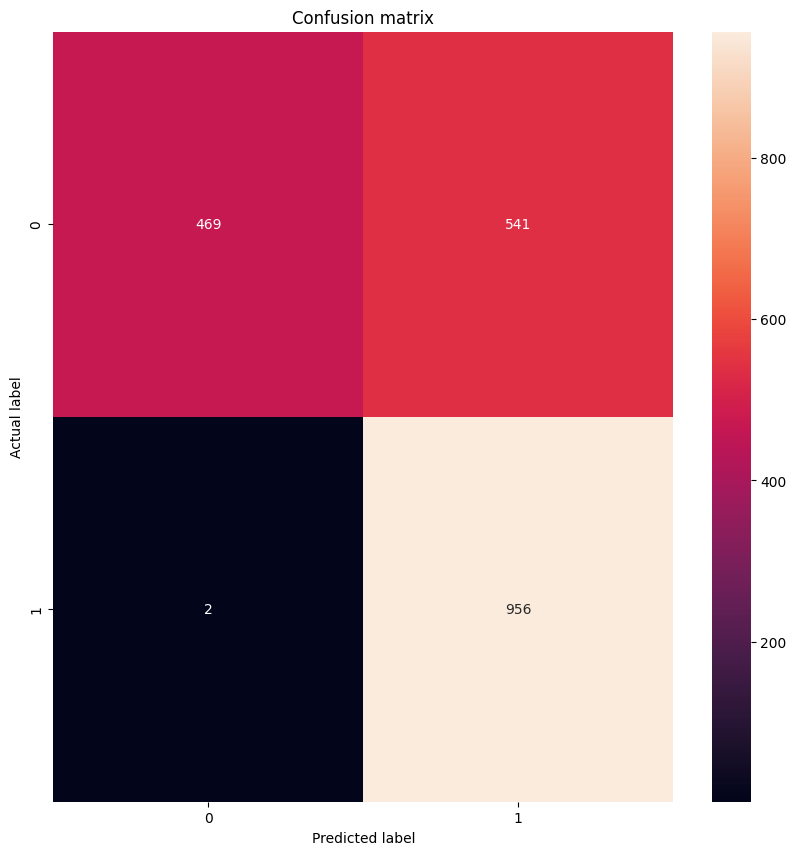

Skipping experiment 11
Skipping experiment 12
Skipping experiment 13
Skipping experiment 14
Skipping experiment 15
Skipping experiment 16
Skipping experiment 17
Skipping experiment 18


<Figure size 640x480 with 0 Axes>

In [67]:
# Common Experiment params
EPOCHS = 20 # Number of training epochs
BATCH_SIZE = 32 # Number of examples used in each training step
NUM_EXAMPLES = 512 # Number of examples to train on

experiments_filter = ["1", "2", "3", "4", "5", "6", "7", "10"]

#------------------ Common preprocessing across experiments -------------------------

# #--------------- FILTER DIGITS -----------------
# x_train_filtered, y_train_filtered, label_mapping = filter_digits(x_train_preprocessed, y_train, digits=params["digits_to_be_filtered"])
# x_test_filtered, y_test_filtered, label_mapping = filter_digits(x_test_preprocessed, y_test, digits=params["digits_to_be_filtered"])

# print("Number of filtered training examples:", len(x_train_filtered))
# print("Number of filtered test examples:", len(x_test_filtered))
# print(pd.Series(y_train_filtered).value_counts().sort_index())
# print(label_mapping)
# y_train_final = y_train_filtered
# y_test_final = y_test_filtered
# print(y_train_final.shape, y_test_final.shape)

#----------------------------- RUN EXPERIMENTS -----------------------------------

for key, params in experiments.items():
    
    if key not in experiments_filter:
        print("Skipping experiment", key)
        continue

    print(key, params)

    #--------------- FILTER DIGITS -----------------
    x_train_filtered, y_train_filtered, label_mapping = filter_digits(x_train_norm, y_train, digits=params["digits_to_be_filtered"])
    x_test_filtered, y_test_filtered, label_mapping = filter_digits(x_test_norm, y_test, digits=params["digits_to_be_filtered"])

    print("Number of filtered training examples:", len(x_train_filtered))
    print("Number of filtered test examples:", len(x_test_filtered))
    print(pd.Series(y_train_filtered).value_counts().sort_index())
    print(label_mapping)
    x_train_final = x_train_filtered
    x_test_final = x_test_filtered
    y_train_final = y_train_filtered
    y_test_final = y_test_filtered
    print(y_train_final.shape, y_test_final.shape)
    plot_MNIST_greyscale(x_train_filtered,y_train_final,label_mapping,image_index=0)

    if params["resize_dims"]:
        #--------------- RESIZE IMAGE -----------------
        x_train_resized = resize_image(x_train_filtered, params["resize_dims"])
        x_test_resized = resize_image(x_test_filtered, params["resize_dims"])

        print("x_train_resized shape:", x_train_resized.shape)
        print("x_test_resized shape:", x_test_resized.shape)
        plot_MNIST_greyscale(x_train_resized,y_train_final,label_mapping,image_index=0)
        x_train_final = x_train_resized
        x_test_final = x_test_resized

    #--------------- SLICE IMAGE -----------------
    central_slice = 1/x_train_final.shape[1]
    if params["centre_h_slicing"]:
        slice_axis = "horizontal"
        x_train_sliced = slice_image(x_train_final, slice_axis, centre_slice=True, central_fraction=central_slice)
        x_test_sliced = slice_image(x_test_final, slice_axis, centre_slice=True, central_fraction=central_slice)

        print("x_train_sliced shape:", x_train_sliced.shape)
        print("x_test_sliced shape:", x_test_sliced.shape)
        x_train_final = x_train_sliced
        x_test_final = x_test_sliced
    else:
        #--------------- FLATTEN IMAGE -----------------
        x_train_flattened = flatten_images(x_train_final)
        x_test_flattened = flatten_images(x_test_final)

        print("x_train_flattened shape:", x_train_flattened.shape)
        print("x_test_flattened shape:", x_test_flattened.shape) 
        x_train_final = x_train_flattened
        x_test_final = x_test_flattened
    
    if params["encoding"] == "FRQI":
        x_train_frqi_encoded = frqi_encoding_all_images(x_train_final)
        print(x_train_frqi_encoded.shape)
        x_test_frqi_encoded = frqi_encoding_all_images(x_test_final)
        print(x_test_frqi_encoded.shape)
        x_train_final = x_train_frqi_encoded
        x_test_final = x_test_frqi_encoded

    print(x_train_final[0])

    plot_MNIST_greyscale(x_train_final,y_train_final,label_mapping,image_index=0)


    #--------------- CREATE QUANTUM ML MODEL -----------------
    model, q_node = create_quantum_model(params["n_qubits"], params["n_layers"], params["gate_sequence"], params["input_shape"], params["encoding"], params["diff_method"])
    
    if params["encoding"] == "amplitude":
        model.predict(x_train_final[0,:].reshape(1,-1))
    else:
        model.predict(x_train_final[0,:])
    print(model.summary())
    plot_model(model, to_file="experiments/experiment_{}/QML_model_experiment_{}.png".format(key, key), show_shapes=True, show_dtype=True, show_layer_names=True)

    #--------------- DRAW CIRCUIT -----------------
    draw_quantum_circuit(q_node, params["n_qubits"],  params["n_layers"])

    #--------------- GET HINGE LOSS LABELS -----------------
    y_train_hinge = get_hinge_labels(y_train_final)
    y_test_hinge = get_hinge_labels(y_test_final)

    #--------------- TRAIN QUANTUM ML MODEL -----------------
    model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

    x_train_sub = x_train_final[:NUM_EXAMPLES,:]
    y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]
    print(x_train_sub.shape, y_train_hinge_sub.shape)

    x_test_sub = x_test_final[:,:]
    y_test_sub = y_test_hinge[:]
    print(x_test_sub.shape, y_test_sub.shape)

    print(len(tf.config.list_physical_devices('GPU')))
    print(tf.config.list_physical_devices('GPU'))

    qnn_history = model.fit(
        x_train_sub, y_train_hinge_sub,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        validation_data=(x_test_sub, y_test_sub))
    
    #--------------- SAVE TRAINING HISTORY -----------------
    experiments[key]["history"] = qnn_history.history
    
    #--------------- EVALUATE QUANTUM ML MODEL -----------------

    qnn_results = model.evaluate(x_test_sub, y_test_sub)
    print(qnn_results)

    #--------------- PRINT RESULTS -----------------
    print("Test loss:", qnn_results[0])
    print("Test accuracy:", qnn_results[1])
    
   #--------------- SAVE RESULTS -----------------
    experiments[key]["results"] = qnn_results

    #--------------- PREDICT ON TEST SET -----------------
    y_pred = model.predict(x_test_sub)
    y_pred = np.where(y_pred > 0, 1, 0)
    y_pred = [label_mapping[i] for i in y_pred]
    y_test_sub = np.where(y_test_sub > 0, 1, 0)
    y_test_sub = [label_mapping[i] for i in y_test_sub]
    print(y_pred)
    print(y_test_sub)
    
    #--------------- CONFUSION MATRIX -----------------
    cm = confusion_matrix(y_test_sub, y_pred)
    print(cm)

    #--------------- PLOT CONFUSION MATRIX -----------------
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig("experiments/experiment_{}/QML_model_experiment_{}_confusion_matrix.png".format(key, key))
    plt.show()
    plt.clf()

    #--------------- SAVE EXPERIMENTS DICT -----------------
    with open('experiments/experiment_{}/experiment_{}_out_{}.json'.format(key, key, datetime.now().strftime("%Y%m%d-%H%M%S")), 'w') as fp:
        json.dump(experiments[key], fp)
    
    with open('experiments/experiments_out_{}.json'.format(datetime.now().strftime("%Y%m%d-%H%M%S")), 'w') as fp:
        json.dump(experiments, fp)

    #--------------- PLOT TRAINING HISTORY -----------------
    plt.plot(qnn_history.history['hinge_accuracy'])
    plt.plot(qnn_history.history['val_hinge_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.savefig("experiments/experiment_{}/QML_model_experiment_{}_accuracy.png".format(key, key))
    plt.clf()

    plt.plot(qnn_history.history['loss'])
    plt.plot(qnn_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.savefig("experiments/experiment_{}/QML_model_experiment_{}_loss.png".format(key, key))
    plt.clf()

    #--------------- SAVE MODEL -----------------
    model.save("experiments/experiment_{}/QML_model_experiment_{}.h5".format(key, key))
    
    #--------------- SAVE MODEL ARCHITECTURE -----------------
    with open("experiments/experiment_{}/QML_model_experiment_{}_architecture.json".format(key, key), "w") as json_file:
        json_file.write(model.to_json())

    #--------------- SAVE MODEL WEIGHTS -----------------
    model.save_weights("experiments/experiment_{}/QML_model_experiment_{}_weights.h5".format(key, key))

    #--------------- CLEAR SESSION -----------------
    tf.keras.backend.clear_session()
    

In [68]:
#------ combine all invidual experiement json into a single json file for easy analysis and comparison -------
import json
import os
import glob

multi_experiments_output = {}
experiment_key_list = []

for filename in glob.glob('experiments/experiment_*/experiment_*_out_*.json'):

    print(filename)
    #----- get folder name -------
    folder_name = filename.split(os.sep)[1]
    experiment_key = folder_name.split("_")[1]
    experiment_key_list.append(experiment_key)
    

    with open(filename, 'r') as fp:
        experiment = json.load(fp)
        multi_experiments_output[experiment_key] = experiment

with open('experiments/experiments_{}_out_{}.json'.format(experiment_key_list, datetime.now().strftime("%Y%m%d-%H%M%S")), 'w') as fp:
    json.dump(multi_experiments_output, fp)
multi_experiments_output

#load above multi_experiments_output json file


experiments\experiment_1\experiment_1_out_20230423-015158.json
experiments\experiment_10\experiment_10_out_20230423-091555.json
experiments\experiment_11\experiment_11_out_20230422-205616.json
experiments\experiment_12\experiment_12_out_20230422-233918.json
experiments\experiment_2\experiment_2_out_20230423-025433.json
experiments\experiment_3\experiment_3_out_20230423-042245.json
experiments\experiment_4\experiment_4_out_20230423-045806.json
experiments\experiment_5\experiment_5_out_20230423-055959.json
experiments\experiment_6\experiment_6_out_20230423-073755.json
experiments\experiment_7\experiment_7_out_20230423-081805.json
experiments\experiment_8\experiment_8_out_20230422-174041.json
experiments\experiment_9\experiment_9_out_20230422-192235.json


{'1': {'digits_to_be_filtered': [3, 6],
  'resize_dims': [9, 9],
  'centre_h_slicing': True,
  'n_qubits': 9,
  'n_layers': 1,
  'gate_sequence': [['RZ', None, 0, [0, 0]],
   ['RY', None, 0, [0, 1]],
   ['RZ', None, 0, [0, 2]],
   ['RZ', None, 1, [1, 0]],
   ['RY', None, 1, [1, 1]],
   ['RZ', None, 1, [1, 2]],
   ['CNOT', 1, 0, None],
   ['RZ', None, 0, [2, 0]],
   ['RY', None, 0, [2, 1]],
   ['RZ', None, 0, [2, 2]],
   ['RZ', None, 2, [3, 0]],
   ['RY', None, 2, [3, 1]],
   ['RZ', None, 2, [3, 2]],
   ['CNOT', 2, 0, None],
   ['RZ', None, 0, [4, 0]],
   ['RY', None, 0, [4, 1]],
   ['RZ', None, 0, [4, 2]],
   ['RZ', None, 3, [5, 0]],
   ['RY', None, 3, [5, 1]],
   ['RZ', None, 3, [5, 2]],
   ['CNOT', 3, 0, None],
   ['RZ', None, 0, [6, 0]],
   ['RY', None, 0, [6, 1]],
   ['RZ', None, 0, [6, 2]],
   ['RZ', None, 4, [7, 0]],
   ['RY', None, 4, [7, 1]],
   ['RZ', None, 4, [7, 2]],
   ['CNOT', 4, 0, None],
   ['RZ', None, 0, [8, 0]],
   ['RY', None, 0, [8, 1]],
   ['RZ', None, 0, [8, 2]],


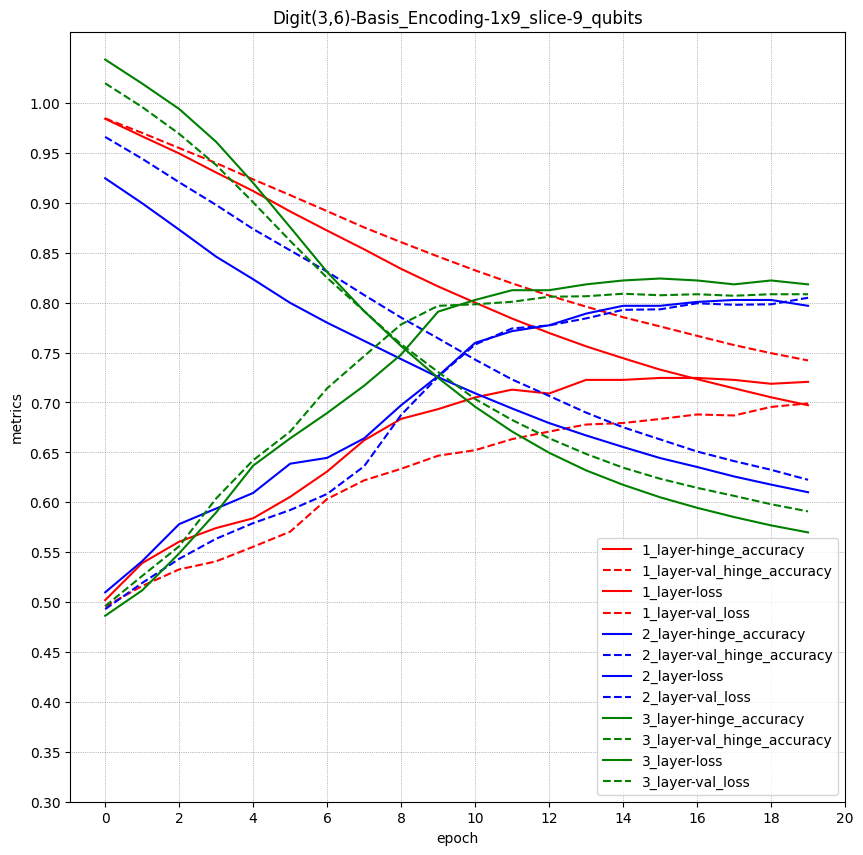

<Figure size 640x480 with 0 Axes>

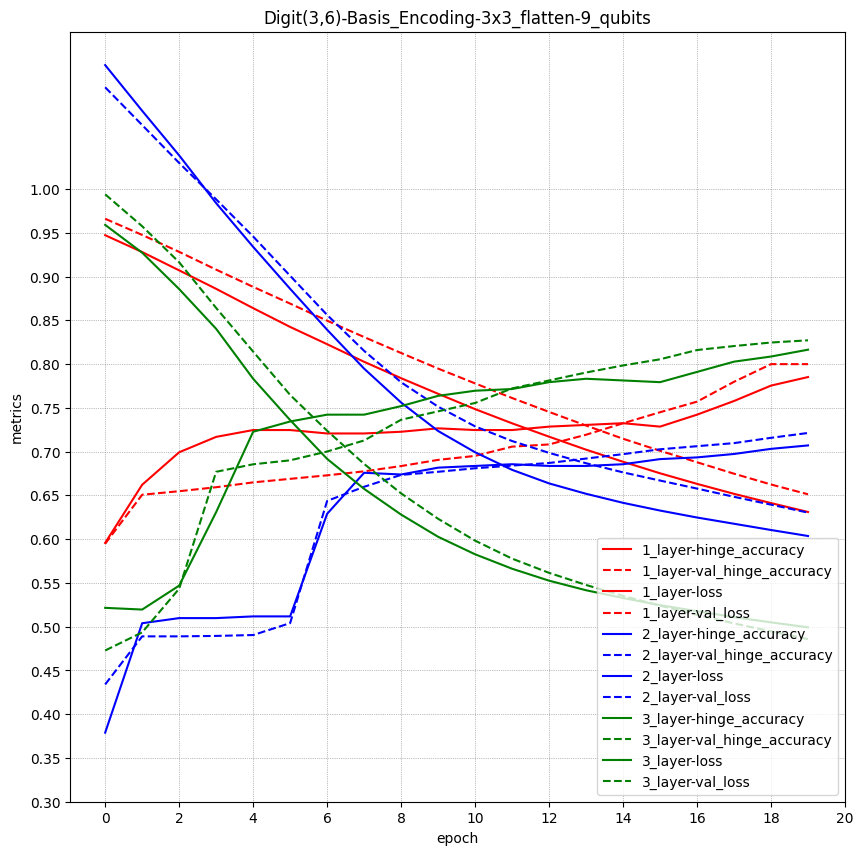

<Figure size 640x480 with 0 Axes>

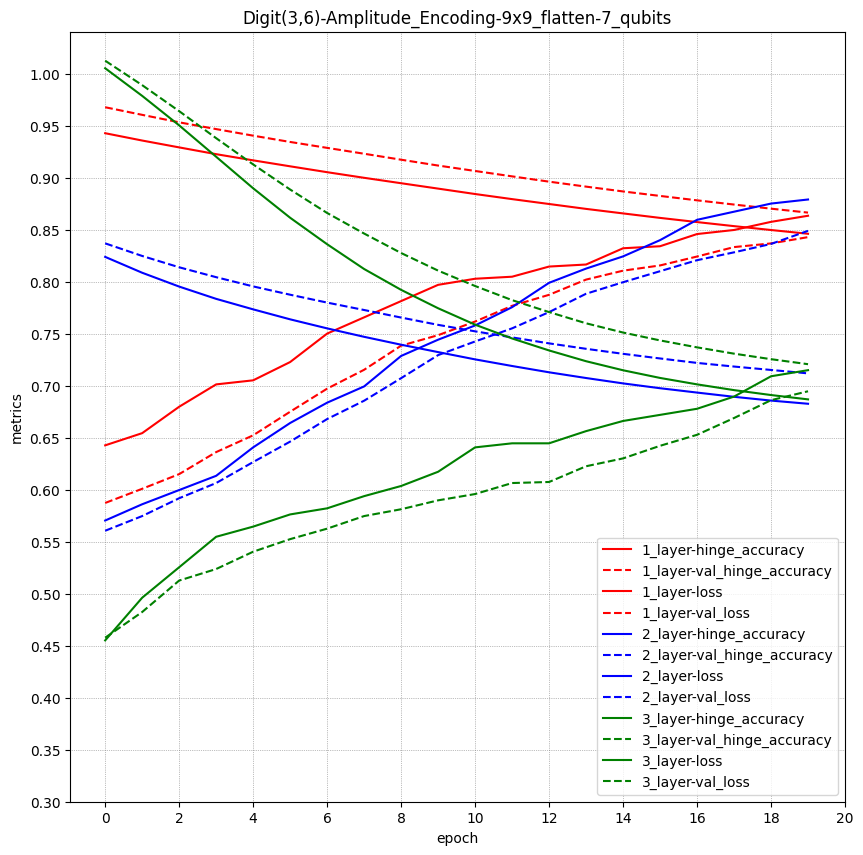

<Figure size 640x480 with 0 Axes>

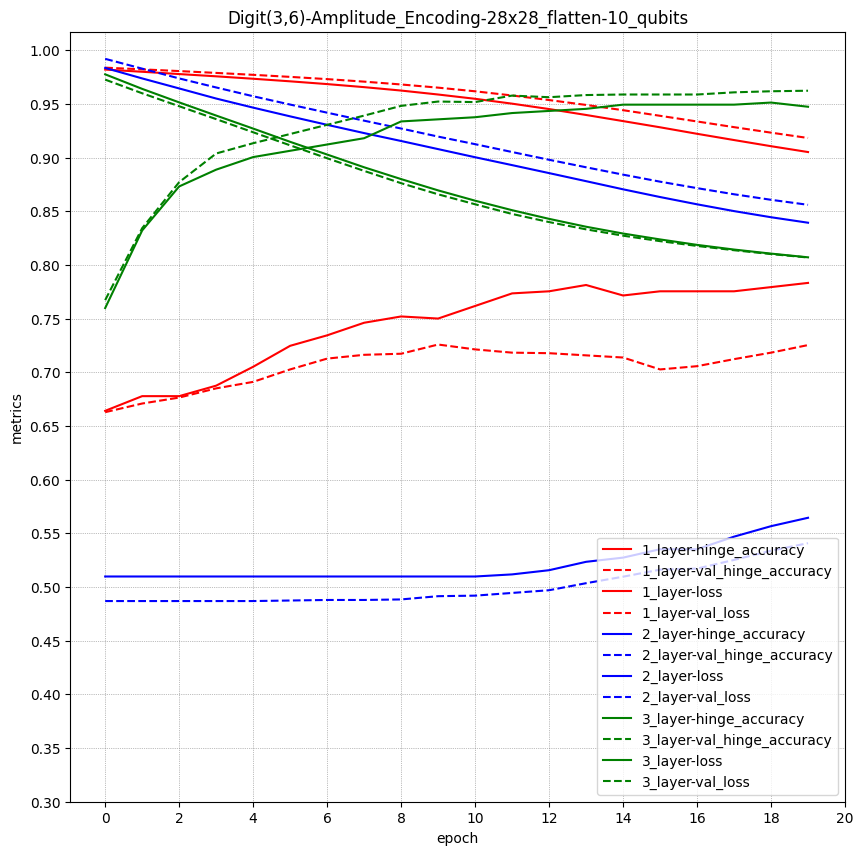

<Figure size 640x480 with 0 Axes>

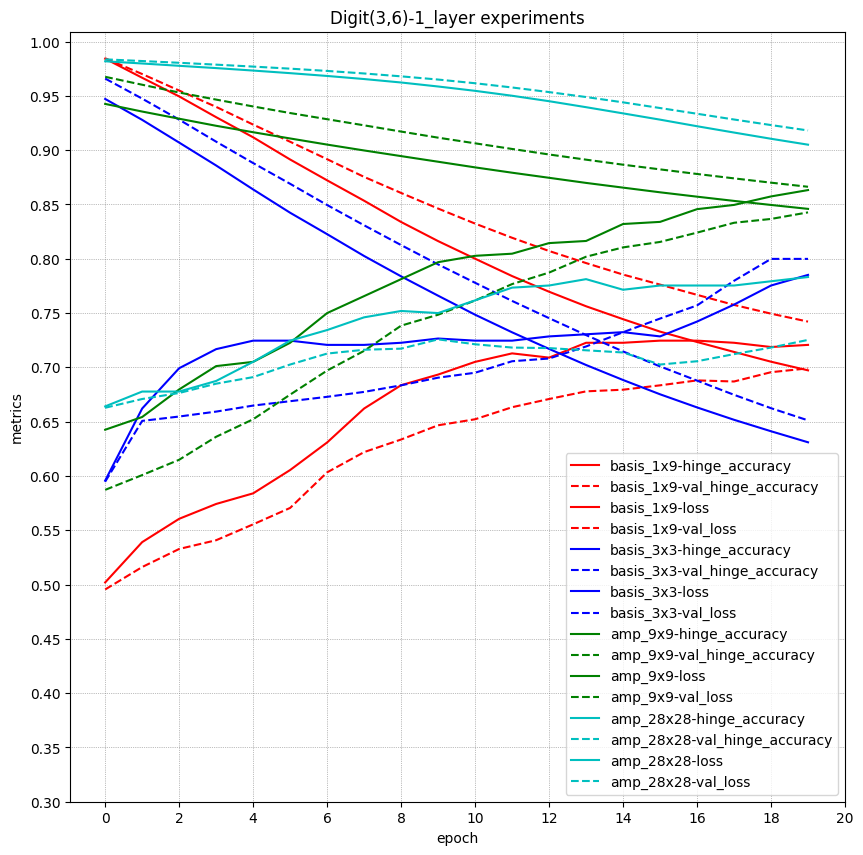

<Figure size 640x480 with 0 Axes>

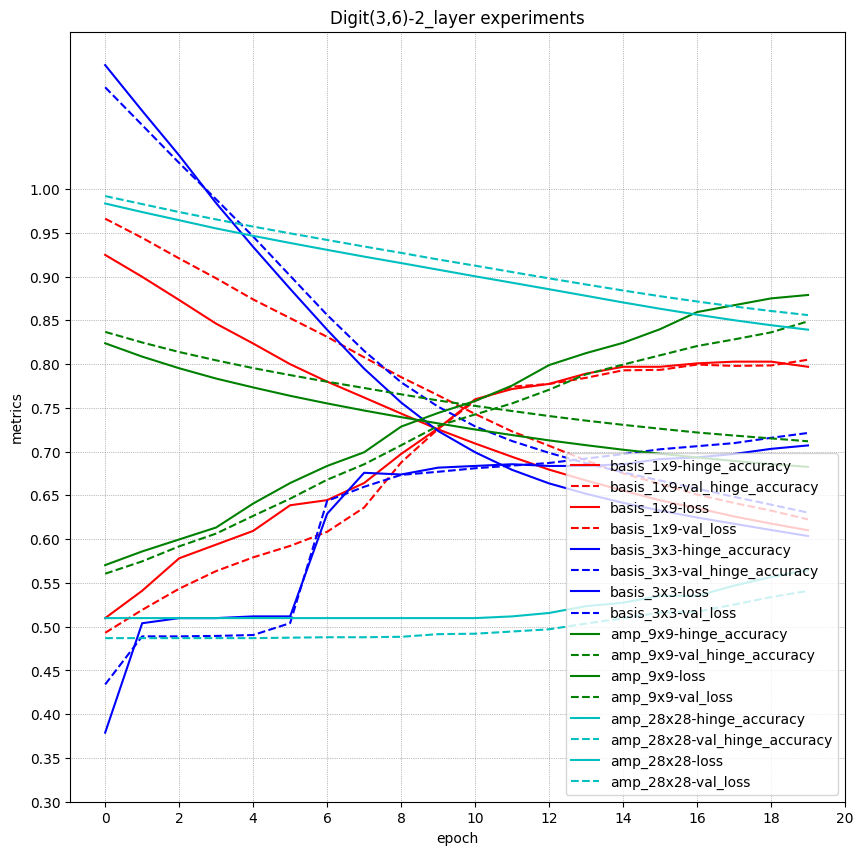

<Figure size 640x480 with 0 Axes>

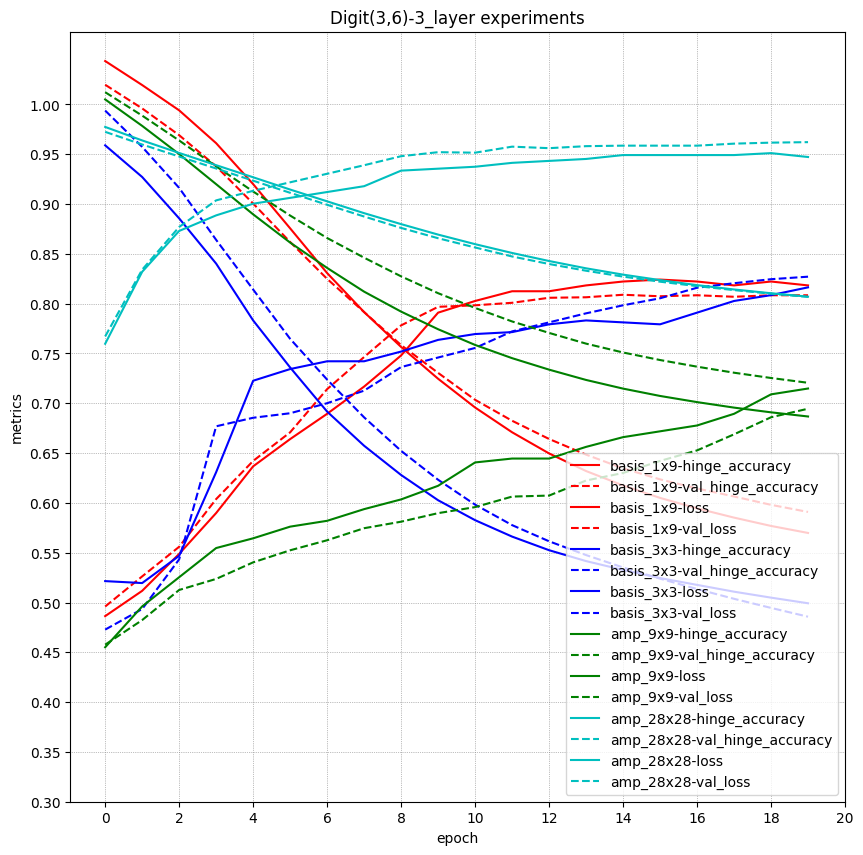

<Figure size 640x480 with 0 Axes>

In [74]:


#------- function for plotting accuracy and loss for multiple experiments together in a single plot for comparison ------------

def plot_experiment_results(experiments, metrics, title, ylabel, filename, plot_label, exp_filter):
    plt.figure(figsize=(10,10))
    
    #--- different experiment has different colours and train and val metrics have different line style for each experiment------

    metric_linestyle = {'hinge_accuracy':'-', 'loss':'-', 'val_hinge_accuracy':'--', 'val_loss':'--'}
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'w']
    experiment_colour = {}
    i=0
    for key in experiments.keys():
        if key in exp_filter:
            experiment_colour[key] = colors[i]
            i+=1
            if isinstance(metrics, list):
                for metric in metrics:
                    plt.plot(experiments[key]["history"][metric], color=experiment_colour[key], linestyle=metric_linestyle[metric], label="{}-{}".format(plot_label[i-1], metric))
            else:
                plt.plot(experiments[key]["history"][metric], color=experiment_colour[key], linestyle=metric_linestyle[metric], label="{}-{}".format(plot_label, metric))

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend(loc='lower right')
    plt.xticks(np.arange(0, 21, 2))
    plt.yticks(np.arange(0.3, 1.05, 0.05))
    plt.grid(color = 'grey', linestyle = ':', linewidth = 0.5)
    plt.savefig(filename)
    plt.show()
    plt.clf()

#----- load multi_experiments_output json file ------
with open("experiments/experiments_['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']_out_20230423-112552.json", 'r') as fp:
    multi_experiments_output = json.load(fp)


history_metrics = ["hinge_accuracy", "val_hinge_accuracy", "loss", "val_loss"]
# ----------- layer comparision plots ----------------
#-- experiments 1,2,3 ------------
experiments_filter=["1","2","3"]
plot_title = "Digit(3,6)-Basis_Encoding-1x9_slice-9_qubits"
plot_label = ["1_layer", "2_layer", "3_layer"]

file_path = "experiments/basis_encoding_1x9_experiments_{}_metrics.png".format(experiments_filter)
plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

#-- experiments 4,5,6 ------------
experiments_filter=["4","5","6"]
plot_title = "Digit(3,6)-Basis_Encoding-3x3_flatten-9_qubits"
file_path = "experiments/basis_encoding_3x3_experiments_{}_metrics.png".format(experiments_filter)
plot_label = ["1_layer", "2_layer", "3_layer"]
plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

#-- experiments 7,8,9 ------------
experiments_filter=["7","8","9"]
plot_title = "Digit(3,6)-Amplitude_Encoding-9x9_flatten-7_qubits"
file_path = "experiments/amplitude_encoding_9x9_experiments_{}_metrics.png".format(experiments_filter)
plot_label = ["1_layer", "2_layer", "3_layer"]
plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

#-- experiments 10,11,12 ------------
experiments_filter=["10","11","12"]
plot_title = "Digit(3,6)-Amplitude_Encoding-28x28_flatten-10_qubits"
file_path = "experiments/amplitude_encoding_28x28_experiments_{}_metrics.png".format(experiments_filter)
plot_label = ["1_layer", "2_layer", "3_layer"]
plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)


# ----------- experiment comparision plots ----------------
#-- experiments 1,4,7,10 ------------
experiments_filter=["1","4","7","10"]
plot_title = "Digit(3,6)-1_layer experiments"
file_path = "experiments/1_layer_experiments_{}_metrics.png".format(experiments_filter)
plot_label = ["basis_1x9", "basis_3x3", "amp_9x9", "amp_28x28"]
plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

#-- experiments 2,5,8,11 ------------
experiments_filter=["2","5","8","11"]
plot_title = "Digit(3,6)-2_layer experiments"
file_path = "experiments/2_layer_experiments_{}_metrics.png".format(experiments_filter)
plot_label = ["basis_1x9", "basis_3x3", "amp_9x9", "amp_28x28"]
plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

#-- experiments 3,6,9,12 ------------
experiments_filter=["3","6","9","12"]
plot_title = "Digit(3,6)-3_layer experiments"
file_path = "experiments/3_layer_experiments_{}_metrics.png".format(experiments_filter)
plot_label = ["basis_1x9", "basis_3x3", "amp_9x9", "amp_28x28"]
plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)




In [ ]:
experiments = {}
# [3,6], 9x9, centre_h_slicing, 9 qubits, ansatz 1, basis encoding, adjoint diff
experiments["1"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":True, "n_qubits":9, "n_layers":1, "gate_sequence":gate_sequence_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
experiments["2"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":True, "n_qubits":9, "n_layers":2, "gate_sequence":gate_sequence_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
experiments["3"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":True, "n_qubits":9, "n_layers":3, "gate_sequence":gate_sequence_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
# [3,6], 3x3, 9 qubits, ansatz 1, basis encoding, adjoint diff
experiments["4"] = {"digits_to_be_filtered":[3,6], "resize_dims":(3,3), "centre_h_slicing":False, "n_qubits":9, "n_layers":1, "gate_sequence":gate_sequence_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
experiments["5"] = {"digits_to_be_filtered":[3,6], "resize_dims":(3,3), "centre_h_slicing":False, "n_qubits":9, "n_layers":2, "gate_sequence":gate_sequence_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
experiments["6"] = {"digits_to_be_filtered":[3,6], "resize_dims":(3,3), "centre_h_slicing":False, "n_qubits":9, "n_layers":3, "gate_sequence":gate_sequence_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
# [3,6], 9x9, 7 qubits, ansatz 2, amplitude encoding, adjoint diff
experiments["7"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":7, "n_layers":1, "gate_sequence":gate_sequence_list[1], "input_shape":81, "encoding":"amplitude", "diff_method":"adjoint"}
experiments["8"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":7, "n_layers":2, "gate_sequence":gate_sequence_list[1], "input_shape":81, "encoding":"amplitude", "diff_method":"adjoint"}
experiments["9"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":7, "n_layers":3, "gate_sequence":gate_sequence_list[1], "input_shape":81, "encoding":"amplitude", "diff_method":"adjoint"}
# [3,6], None, 10 qubits, ansatz 4, amplitude encoding, adjoint diff
experiments["10"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":10, "n_layers":1, "gate_sequence":gate_sequence_list[3], "input_shape":784, "encoding":"amplitude", "diff_method":"adjoint"}
experiments["11"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":10, "n_layers":2, "gate_sequence":gate_sequence_list[3], "input_shape":784, "encoding":"amplitude", "diff_method":"adjoint"}
experiments["12"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":10, "n_layers":3, "gate_sequence":gate_sequence_list[3], "input_shape":784, "encoding":"amplitude", "diff_method":"adjoint"}
# [3,6], 9x9, 8 qubits, ansatz 3, FRQI encoding, adjoint diff
experiments["13"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":1, "gate_sequence":gate_sequence_list[2], "input_shape":162, "encoding":"FRQI", "diff_method":"adjoint"}
experiments["14"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":2, "gate_sequence":gate_sequence_list[2], "input_shape":162, "encoding":"FRQI", "diff_method":"adjoint"}
experiments["15"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "gate_sequence":gate_sequence_list[2], "input_shape":162, "encoding":"FRQI", "diff_method":"adjoint"}
# [3,6], None, 11 qubits, ansatz 5, FRQI encoding, adjoint diff
experiments["16"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":11, "n_layers":1, "gate_sequence":gate_sequence_list[4], "input_shape":1568, "encoding":"FRQI", "diff_method":"adjoint"}
experiments["17"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":11, "n_layers":2, "gate_sequence":gate_sequence_list[4], "input_shape":1568, "encoding":"FRQI", "diff_method":"adjoint"}
experiments["18"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":11, "n_layers":3, "gate_sequence":gate_sequence_list[4], "input_shape":1568, "encoding":"FRQI", "diff_method":"adjoint"}


[3, 6, 3, 6, 3, 3, 3, 6, 6, 3, 3, 6, 3, 3, 3, 3, 6, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 6, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 3, 6, 6, 3, 3, 6, 6, 3, 3, 3, 6, 3, 6, 6, 6, 3, 3, 3, 6, 6, 3, 6, 3, 3, 3, 3, 6, 3, 3, 6, 3, 6, 6, 6, 3, 3, 3, 3, 3, 6, 3, 3, 3, 6, 3, 6, 3, 3, 6, 6, 6, 6, 6, 3, 3, 6, 3, 6, 3, 6, 6, 6, 3, 3, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 6, 6, 3, 6, 3, 6, 6, 3, 3, 6, 6, 3, 3, 3, 6, 6, 3, 3, 6, 3, 6, 6, 3, 3, 3, 3, 3, 3, 6, 6, 3, 3, 6, 3, 6, 3, 3, 3, 3, 3, 6, 6, 6, 3, 3, 6, 6, 3, 6, 3, 6, 3, 3, 6, 6, 3, 3, 3, 3, 3, 6, 6, 3, 3, 6, 3, 6, 3, 6, 6, 6, 3, 6, 6, 3, 3, 6, 6, 6, 3, 6, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 3, 3, 3, 6, 3, 3, 3, 6, 3, 6, 3, 6, 6, 6, 3, 3, 3, 3, 6, 3, 6, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 3, 3, 3, 6, 6, 3, 6, 6, 6, 3, 3, 6, 3, 6, 6, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 6, 6, 3, 3, 6, 6, 3, 3, 3, 6, 3, 6, 3, 3, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 6, 6, 3, 3, 3, 3, 3, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 6, 3, 3, 3, 6, 3, 6, 3, 3, 3, 6, 3, 3, 3, 3, 3, 6, 6, 3, 

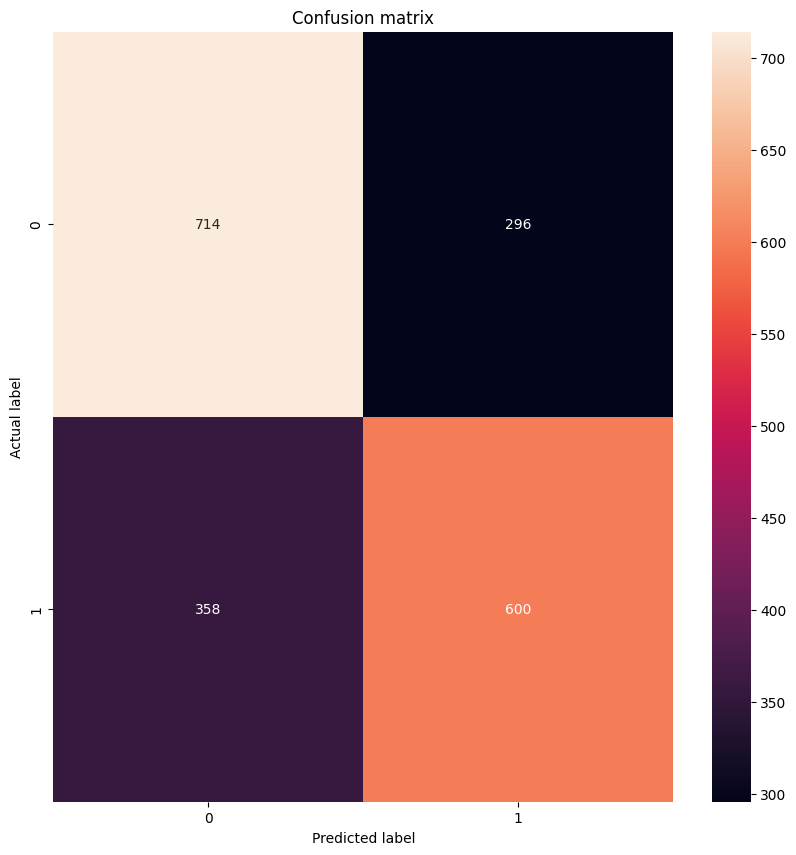

<Figure size 640x480 with 0 Axes>

In [ ]:
key = 1

print(y_pred)
print(y_test_sub)

#--------------- CONFUSION MATRIX -----------------
cm = confusion_matrix(y_test_sub, y_pred)
print(cm)

#--------------- PLOT CONFUSION MATRIX -----------------
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# plt.savefig("experiments/experiment_{}/QML_model_experiment_{}_confusion_matrix.png".format(key, key))
plt.show()
plt.clf()

In [ ]:
key=1
#--------------- LOAD MODEL -----------------
loaded_model = tf.keras.models.load_model("QML_model_experiment_{}.h5".format(key), custom_objects={"hinge_accuracy": hinge_accuracy})

#--------------- PREDICT ON TEST SET -----------------
y_pred = loaded_model.predict(x_test_sub)
y_pred = np.argmax(y_pred, axis=1)
y_pred = [label_mapping[i] for i in y_pred]
y_test_sub = [label_mapping[i] for i in y_test_sub]

#--------------- CONFUSION MATRIX -----------------
cm = confusion_matrix(y_test_sub, y_pred)
print(cm)

#--------------- PLOT CONFUSION MATRIX -----------------
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig("QML_model_experiment_{}_confusion_matrix.png".format(key))
plt.clf()


ValueError: Unknown layer: KerasLayer. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
# plot the hinge accuracy for the qnn history for both 1 and 2 layer on the same axes
plt.plot(np.arange(1,21), qnn_history_1layer.history["hinge_accuracy"], label="TRAIN - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_1layer.history["val_hinge_accuracy"], label="VAL - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["hinge_accuracy"], label="TRAIN - 2 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["val_hinge_accuracy"], label="VAL - 2 layer QNN")
plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("qnn_hinge_accuracy.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
# plot the hinge accuracy for the loss for both 1 and 2 layer on the same axes
plt.plot(np.arange(1,21), qnn_history_1layer.history["loss"], label="TRAIN - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_1layer.history["val_loss"], label="VAL - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["loss"], label="TRAIN - 2 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["val_loss"], label="VAL - 2 layer QNN")
plt.xlabel("Epoch")
plt.ylabel("Hinge Loss")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("qnn_hinge_loss.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
def plot_accuracy_and_loss(histories, layers, filename_prefix, hue_start=0, hue_end=1):
    colors = plt.cm.get_cmap('viridis', len(layers))

    for metric in ["hinge_accuracy", "loss"]:
        plt.figure()
        for i, layer in enumerate(layers):
            label_prefix = f"{layer}-layer QNN"
            color = colors(hue_start + i * (hue_end - hue_start) / (len(layers) - 1))
            
            plt.plot(np.arange(1, 21), histories[i].history[metric], label=f"TRAIN - {label_prefix}", color=color)
            plt.plot(np.arange(1, 21), histories[i].history[f"val_{metric}"], label=f"VAL - {label_prefix}", linestyle="--", color=color)

        plt.xlabel("Epoch")
        plt.ylabel("Hinge Accuracy" if metric == "hinge_accuracy" else "Hinge Loss")
        plt.legend()
        plt.xticks(np.arange(0, 21, 2.5))
        plt.savefig(f"{filename_prefix}_{metric}.pdf", bbox_inches="tight", pad_inches=0)
        plt.show()

# Example usage:
qnn_histories = [qnn_history_1layer, qnn_history_2layer]
layers = [1, 2]
plot_accuracy_and_loss(qnn_histories, layers, "qnn")